In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tkinter
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter
import plotly.graph_objects as go
import matplotlib.ticker as mtick

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Initial Data Checking ###

In [4]:
raw_df = pd.read_csv('/content/drive/MyDrive/Projects/SLF - Experiment/Churn Customer/WA_Fn-UseC_-Telco-Customer-Churn.csv')

let's check the column names and data types!

In this dataset, we have 21 columns with "Churn" Column as the target. Let's check the target column composition

In [5]:
raw_df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

We can see that the dataset itself is imbalanced. This could pose problem later, which we will discuss in detail. But First, let's check the other columns!

In [6]:
raw_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
raw_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


As we compare the column list and the glance of the dataframe, it's supposed to be 4 numerical column & 17 Categorical column. However, we could see in the data types, we have only 3 numerical column. This could be due to the data in the TotalCharges Column still have some text values.

But first, let's check if the column has any missing values

In [8]:
raw_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Here we see that all the columns has no missing values, However, sometimes missing values simply is not NaN (Not A Number), but some unintelligible values due to typos/entry error. And as previously mentioned, perhaps TotalCharges Column has missing values that are text that needs to be converted!

In [9]:
raw_df['TotalCharges'] = pd.to_numeric(raw_df['TotalCharges'])

ValueError: Unable to parse string " " at position 488

as expected, there are missing values in the column as whitespace " ", we can check how many are affected.

In [10]:
raw_df[raw_df['TotalCharges'] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


As we can see, there are 11 rows that has the " " problem in the TotalCharges Column. One of the way is either, to impute the values with mean or median of the column, or just simply remove it. Since it is apparent that all the rows has not churned yet, and we have abundance of it, personally I would just remove it.

In [11]:
raw_df_new = raw_df[~(raw_df['TotalCharges'] == " ")].copy()
raw_df_new['TotalCharges']= pd.to_numeric(raw_df_new['TotalCharges'])

In [12]:
raw_df_new.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

The TotalCharges is already converted into numerical! Let's see each column's unique values!

In [13]:
columns = raw_df_new.columns
print("******************* Numeric field *******************\n")
for i in range(len(columns)):
    if raw_df_new[columns[i]].dtypes!=object:
        print("unique number of {} -> {}".format(columns[i], len(raw_df_new[columns[i]].unique())))

print("\n******************* Categorical field *******************\n")
for i in range(len(columns)):
    if raw_df_new[columns[i]].dtypes==object:
        print("unique number of {} -> {}".format(columns[i], len(raw_df_new[columns[i]].unique())))

******************* Numeric field *******************

unique number of SeniorCitizen -> 2
unique number of tenure -> 72
unique number of MonthlyCharges -> 1584
unique number of TotalCharges -> 6530

******************* Categorical field *******************

unique number of customerID -> 7032
unique number of gender -> 2
unique number of Partner -> 2
unique number of Dependents -> 2
unique number of PhoneService -> 2
unique number of MultipleLines -> 3
unique number of InternetService -> 3
unique number of OnlineSecurity -> 3
unique number of OnlineBackup -> 3
unique number of DeviceProtection -> 3
unique number of TechSupport -> 3
unique number of StreamingTV -> 3
unique number of StreamingMovies -> 3
unique number of Contract -> 3
unique number of PaperlessBilling -> 2
unique number of PaymentMethod -> 4
unique number of Churn -> 2


Based on the above, most of categorical field only has 2 to 4 unique values (except customerID of course). We shall dig deeper in the next section for the EDA.

### Exploratory Data Analysis (EDA) ###

As previously mentioned, the CustomerID column could be ignored and we will remove it later on. Based on the column description and titles, perhaps we could group them as follows:
- Gender, SeniorCitizen, Partner, Dependents could be grouped as Demographics
- Multiplelines, InternetService, OnlineSecurity, Onlinebackup, DeviceProtections, Techsupport, StreamingTV & Streaming Movies could be grouped as services subscribed
- Contract, PaperlessBilling,Paymentmethod, Monthlycharges, TotalCharges and Tenure could be grouped as Billing & Tenure
- While Churn itself is the Target Variable

We shall see the correlation between the target and respective columns in the next sub-section.

#### A. Demographics ####

Let's see the gender distribution with churn, if either gender has tendencies to churn:

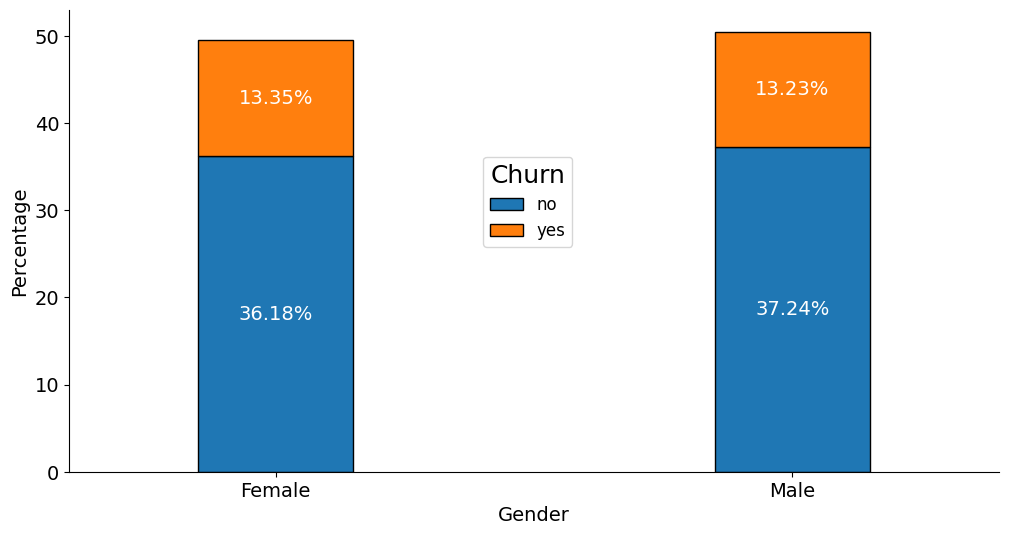

In [14]:
gender_churn_percentage = (raw_df_new.groupby(['gender', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()

fig, ax = plt.subplots(figsize = (12, 6))

gender_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax,
        width = 0.3,
        edgecolor = "black")

for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'white')
# Remove spines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
# Add labels
ax.tick_params(labelsize = 14, labelrotation = 0)
ax.set_ylabel("Percentage", size = 14)
ax.set_xlabel("Gender", size = 14)
# Add legend
ax.legend(labels = ["no", "yes"],
          fontsize = 12,
          title = "Churn",
          title_fontsize = 18,
          bbox_to_anchor = [0.55, 0.7])

Looking at the barchart above, the difference between the gender in terms of churned customer is very little so we could say that it is evenly distributed between those two. Let's take a look for the SeniorCitizen

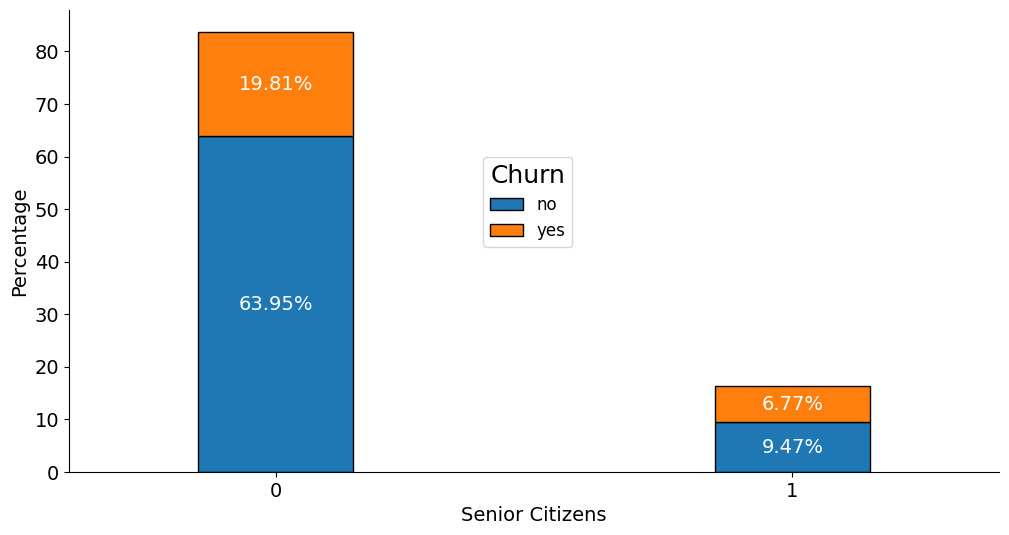

In [15]:
senior_churn_percentage = (raw_df_new.groupby(['SeniorCitizen', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()
fig, ax = plt.subplots(figsize = (12, 6))

senior_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax,
        width = 0.3,
        edgecolor = "black")

# Add labels
for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'white')
# Remove spines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
# Add labels
ax.tick_params(labelsize = 14, labelrotation = 0)
ax.set_ylabel("Percentage", size = 14)
ax.set_xlabel("Senior Citizens", size = 14)
# Add legend
ax.legend(labels = ["no", "yes"],
          fontsize = 12,
          title = "Churn",
          title_fontsize = 18,
          bbox_to_anchor = [0.55, 0.7])

Most of senior citizen churns compared to the non-senior citizens. However, senior citizens population is already small to begin with. Let's move on to the Partners & Dependents

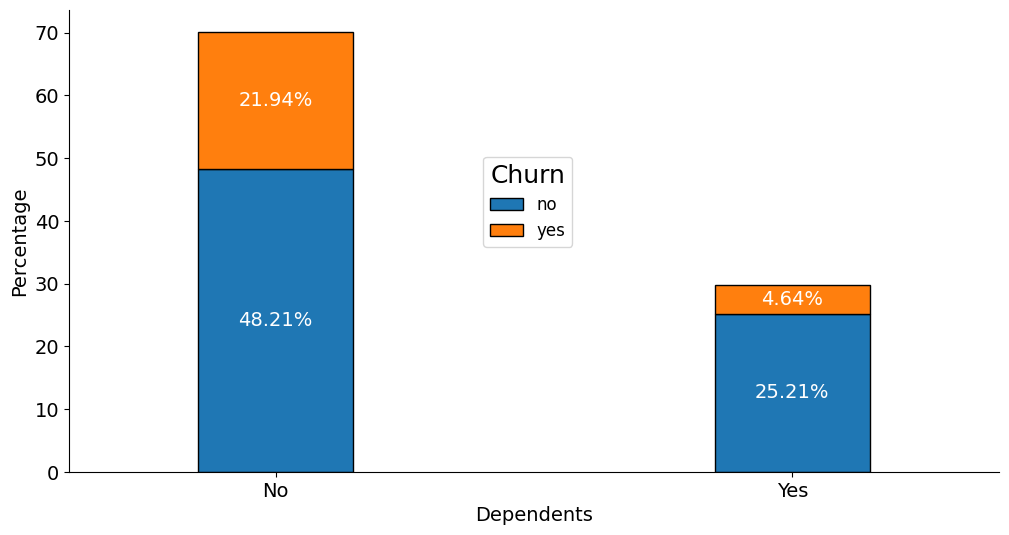

In [16]:
dependents_churn_percentage = (raw_df_new.groupby(['Dependents', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()

fig, ax = plt.subplots(figsize = (12, 6))

dependents_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax,
        width = 0.3,
        edgecolor = "black")

# Add labels
for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'white')
# Remove spines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
# Add labels
ax.tick_params(labelsize = 14, labelrotation = 0)
ax.set_ylabel("Percentage", size = 14)
ax.set_xlabel("Dependents", size = 14)
# Add legend
ax.legend(labels = ["no", "yes"],
          fontsize = 12,
          title = "Churn",
          title_fontsize = 18,
          bbox_to_anchor = [0.55, 0.7])

Interestingly, people with dependents tend to churn less compared to people with no Dependents, even 5 times less! let's see the Partners.

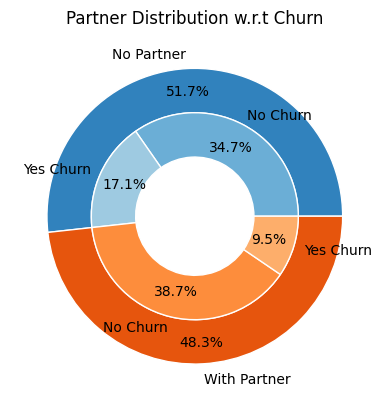

In [17]:
#filtering dataframes only for Partner & Churn column for easier procesing
df_prt_chrn = raw_df_new[['Partner', 'Churn']].copy()

outer = df_prt_chrn.groupby('Partner').count()
inner = df_prt_chrn.groupby(['Partner']).Churn.value_counts()

fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.get_cmap('tab20c')
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

groups = ['No Partner', 'With Partner']
subgroups = ['No Churn', 'Yes Churn', 'No Churn', 'Yes Churn']

ax.pie(outer.values.flatten(), radius=1, colors = outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=groups,
       autopct='%1.1f%%', pctdistance=0.85)

ax.pie(inner.values.flatten(), radius=1-size, colors = inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels = subgroups,
       autopct='%1.1f%%', pctdistance=0.75)

ax.set(aspect="equal", title='Partner Distribution w.r.t Churn')
plt.show()


Judging from the nested pie chart, the distribution between partners and no partner are almost equal. However, if we look closer, customers with partners that churned are almost the half of the customers with No partner.

The trend is similar with People with dependents, people without dependents/partners tend to churn more compared to people with Partner/ Dependents.

#### B. Services Subscribed ####

Let's draw all the Services Subsricbed column simultaneously!

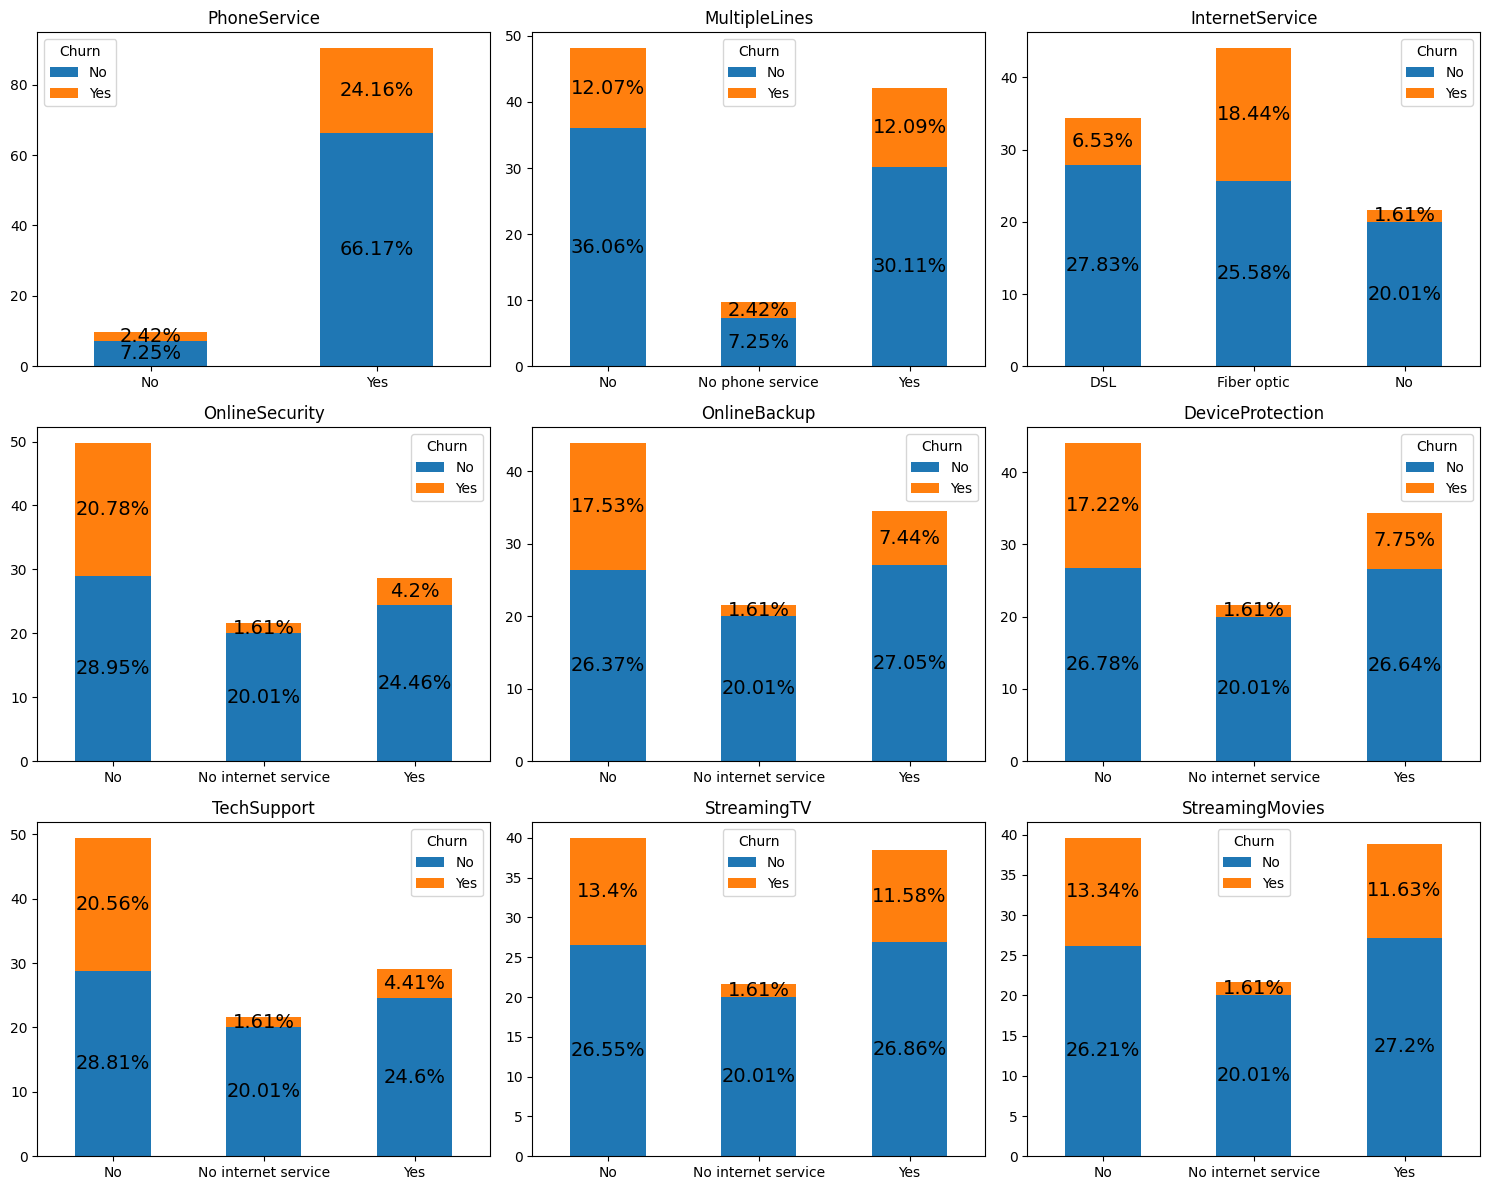

In [18]:
### Create a list of columns that we want to draw
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

### create smaller dataframe compared to the target column
grouped_dfs = {}

for col in services:
    grouped_dfs[col] = (raw_df_new.groupby([col, 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()

### Draw each dataframe
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, item in enumerate(services):
    row_index = i // 3
    col_index = i % 3

    ax = grouped_dfs[item].plot(kind='bar', stacked=True, ax=axes[row_index, col_index], rot=0)

    # Set title for each subplot
    ax.set_title(item)

    # Remove the bottom title
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add numbers on each bar
    for c in ax.containers:
        labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c,
                     label_type='center',
                     labels = labels,
                     size = 14,
                     color = 'black')

plt.tight_layout()
plt.show()


At a glance, we could see that the PhoneService and Multiple lines are just a detailed breakdown of the PhoneService, and between the customers who has singular vs multiple lines has no huge difference whatsoever. As for the InternetService, it only divides between FO vs DSL, which has no interesting point except FO users has high tendency to churn.

As for the other 6 columns (OnlineSecurity, OnlineBackup,Deviceprotection,...Etc) the churn distribution is very similar between the columns. I think it will be much more interesting if we see the distribution between customers that subscribe none of the 6 columns to the ones who subscribed them all. Let's combine the columns to create a new column!

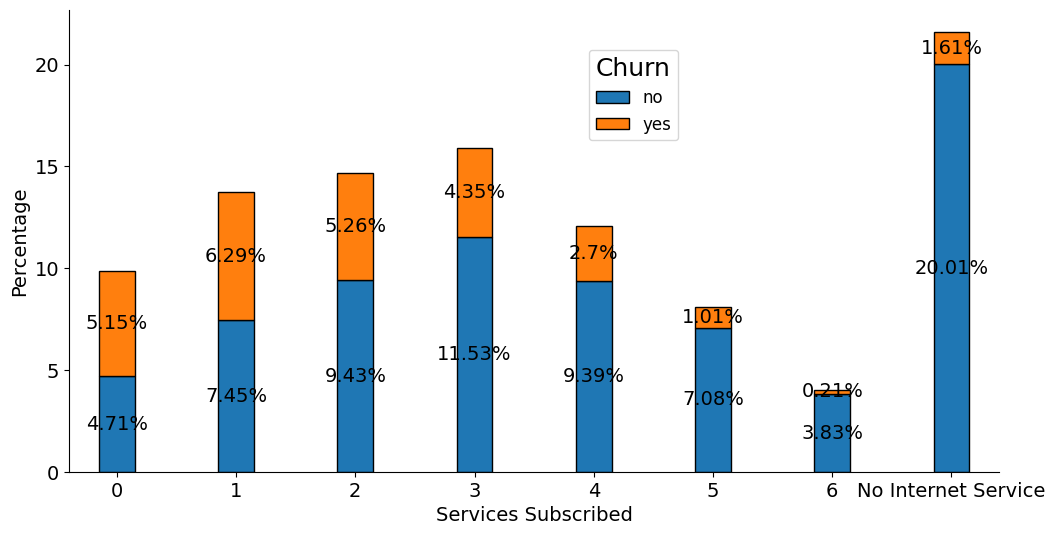

In [19]:
### create a smaller dataframe so it'll be easier to manipulate
service_subscribed = raw_df_new[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Churn']].copy()

### convert the categorical values to numerical so it is easier to calculate the sum of subscription
dic = {'Yes': 1, 'No':0, 'No internet service': -999}

### columns that need the value to be changed
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']
### replace the value
for column in columns_to_replace:
    service_subscribed[column].replace(dic, inplace=True)

### aggregate the sum of the row to see each customer's total services subscribed
service_subscribed['Sum'] = service_subscribed[service_subscribed.columns[0:6]].sum(axis=1)

###  -999 times 6 = -5994 means that the rows that contains -5994 has no internet service at all
service_subscribed['Sum'] = service_subscribed['Sum'].replace(-5994, 'No Internet Service')

###Groupby so we could draw it!
service_churn_percentage = (service_subscribed.groupby(['Sum', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()

fig, ax = plt.subplots(figsize = (12, 6))

service_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax,
        width = 0.3,
        edgecolor = "black")

for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'black')
# Remove spines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
# Add labels
ax.tick_params(labelsize = 14, labelrotation = 0)
ax.set_ylabel("Percentage", size = 14)
ax.set_xlabel("Services Subscribed", size = 14)
# Add legend
ax.legend(labels = ["no", "yes"],
          fontsize = 12,
          title = "Churn",
          title_fontsize = 18,
          bbox_to_anchor = [0.55, 0.7])

After creating a new column, we could see an interesting trend that the less services subscribed by the customer, the more customer inclined to churn. Customer that has no internet service at all even has much less churn rate compared to the 4 services subscribed customer group.

#### C. Billing & Tenure ####

Now we will check the Billing & Tenure Columns

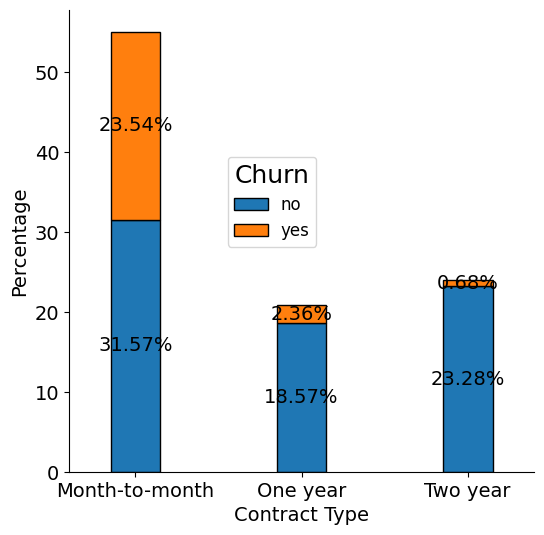

In [20]:
contract_churn_percentage = (raw_df_new.groupby(['Contract', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()

fig, ax = plt.subplots(figsize = (6, 6))

contract_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax,
        width = 0.3,
        edgecolor = "black")


for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'black')

for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

ax.tick_params(labelsize = 14, labelrotation = 0)
ax.set_ylabel("Percentage", size = 14)
ax.set_xlabel("Contract Type", size = 14)

ax.legend(labels = ["no", "yes"],
          fontsize = 12,
          title = "Churn",
          title_fontsize = 18,
          bbox_to_anchor = [0.55, 0.7])


It is clear to see that the highest churn percentage will be from the Month-to-month contract, since it's easier for them to stop the subscription compared to the ones who are commited for one/two year contract.

Text(0, 0.5, 'Count')

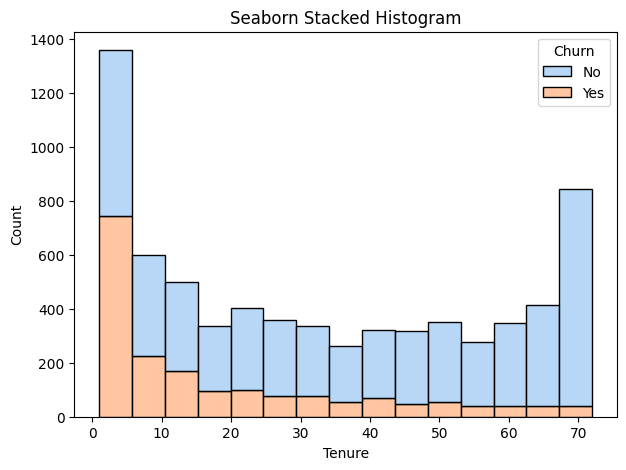

In [21]:

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=raw_df_new, ax=ax, stat="count", multiple="stack",
             x="tenure", kde=False,
             palette="pastel", hue="Churn",
             element="bars", legend=True)
ax.set_title("Seaborn Stacked Histogram")
ax.set_xlabel("Tenure")
ax.set_ylabel("Count")

Interesting to see that most customer churns where the tenure is still early,  around 0-10 months and then dips steadily. Let's check the comparison of tenure between contracts.

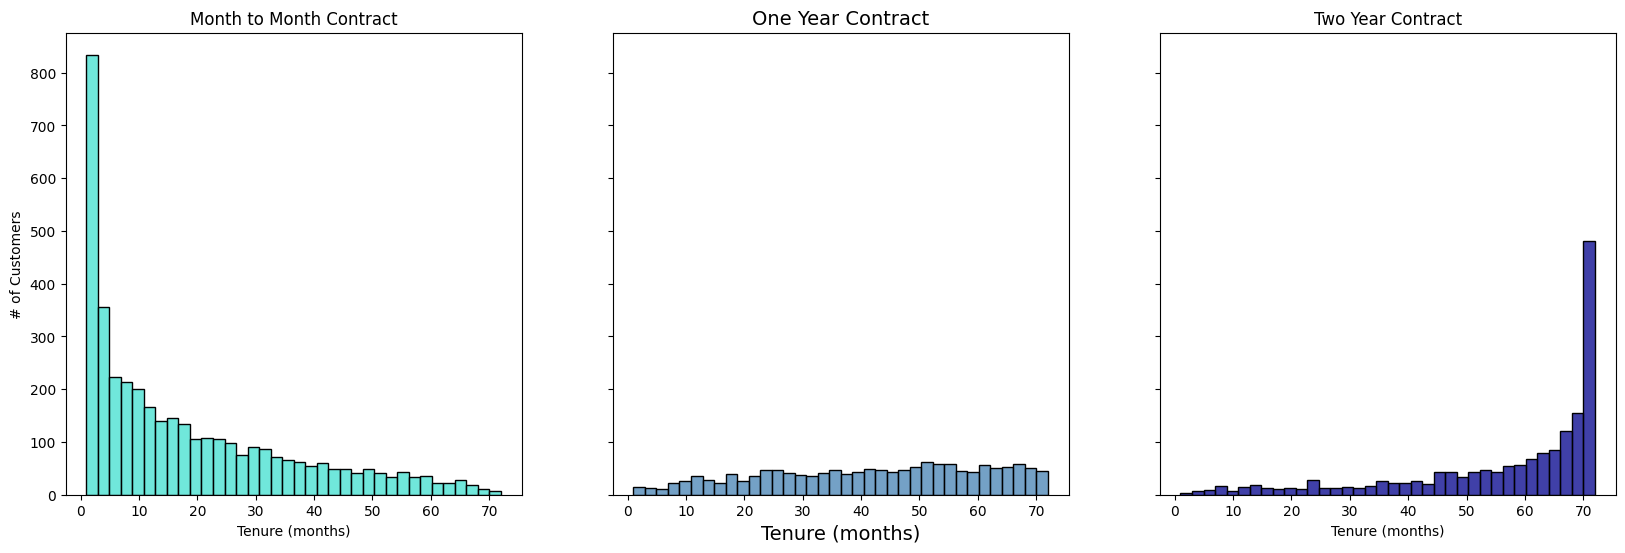

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 6))

sns.histplot(data=raw_df_new[raw_df_new['Contract'] == 'Month-to-month'],
             x='tenure', kde=False, bins=int(180/5), color='turquoise',
             edgecolor='black', linewidth=1, ax=ax1)
ax1.set_ylabel('# of Customers')
ax1.set_xlabel('Tenure (months)')
ax1.set_title('Month to Month Contract')

sns.histplot(data=raw_df_new[raw_df_new['Contract'] == 'One year'],
             x='tenure', kde=False, bins=int(180/5), color='steelblue',
             edgecolor='black', linewidth=1, ax=ax2)
ax2.set_xlabel('Tenure (months)', size=14)
ax2.set_title('One Year Contract', size=14)

sns.histplot(data=raw_df_new[raw_df_new['Contract'] == 'Two year'],
             x='tenure', kde=False, bins=int(180/5), color='darkblue',
             edgecolor='black', linewidth=1, ax=ax3)
ax3.set_xlabel('Tenure (months)')
ax3.set_title('Two Year Contract')

plt.show()


The distribution between three contract types are compelling. Most of the customers in two year contract stays with the company even reaching 70 months, indicating that the customers who has chosen 2-year contract are commited and loyal extending its contract. On the other hand, the distribution of tenure months in 1-year contract shows no difference across tenure whatsoever.

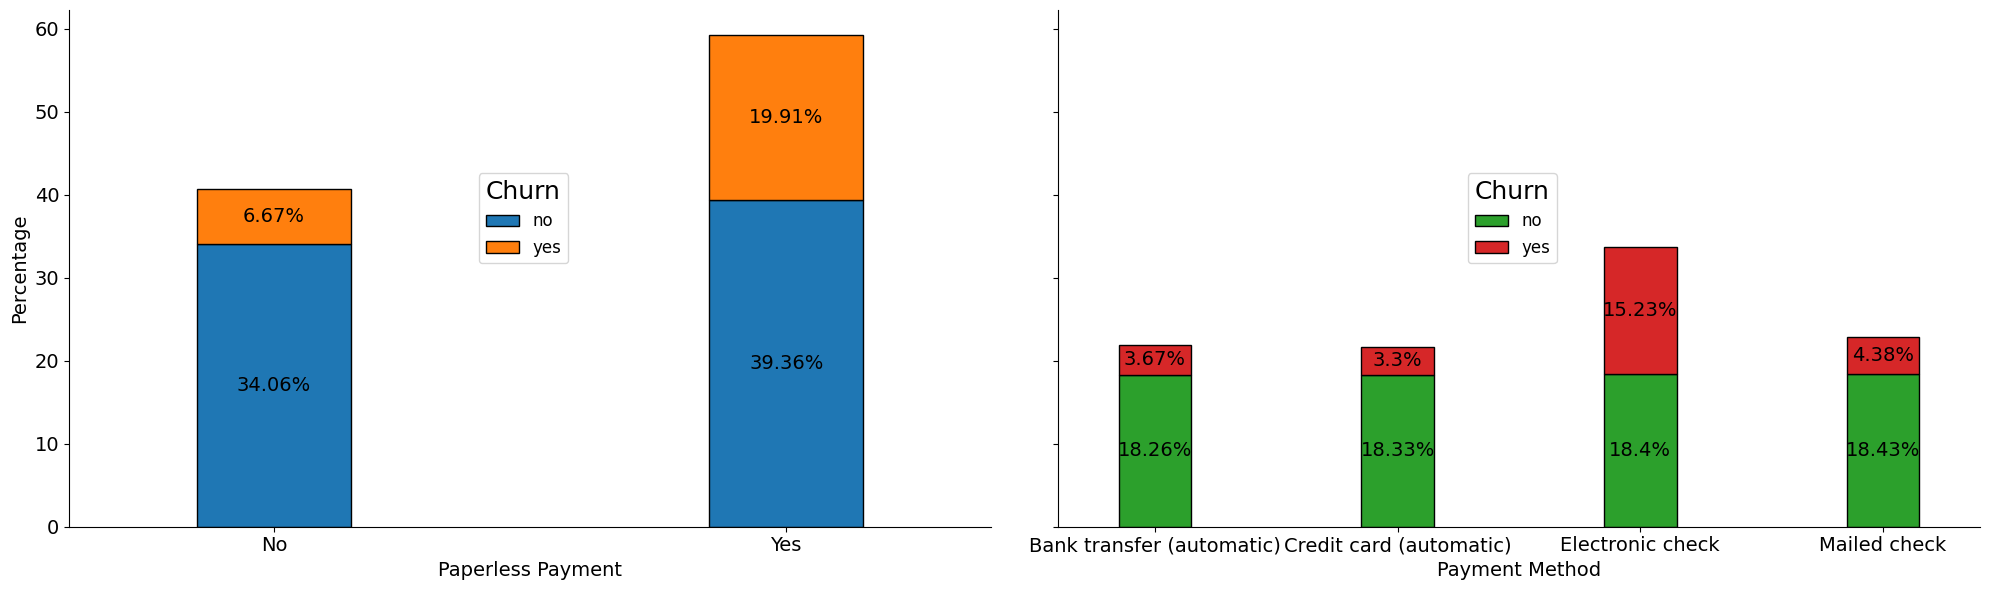

In [23]:
paperless_churn_percentage = (raw_df_new.groupby(['PaperlessBilling', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()
method_churn_percentage = (raw_df_new.groupby(['PaymentMethod', 'Churn']).size() * 100.0 / len(raw_df_new)).unstack()

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 6))


color_paperless_churn = ["#1f77b4", "#ff7f0e"]
color_other_data = ["#2ca02c", "#d62728"]

paperless_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax,
        width = 0.3,
        edgecolor = "black",
        color=color_paperless_churn)

method_churn_percentage.plot(kind = "bar",
        stacked = True,
        ax = ax2,
        width = 0.3,
        edgecolor = "black",
        color=color_other_data)

for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'black')

for c in ax2.containers:
    labels = [str(round(v.get_height(), 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax2.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 14,
                color = 'black')


for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)


ax.tick_params(labelsize=14, labelrotation=0)
ax.set_ylabel("Percentage", size=14)
ax.set_xlabel("Paperless Payment", size=14)
ax.legend(labels=["no", "yes"],
          fontsize=12,
          title="Churn",
          title_fontsize=18,
          bbox_to_anchor=[0.55, 0.7])


ax2.tick_params(labelsize=14, labelrotation=0)
ax2.set_ylabel("Percentage", size=14)
ax2.set_xlabel("Payment Method", size=14)
ax2.legend(labels=["no", "yes"],
           fontsize=12,
           title="Churn",
           title_fontsize=18,
           bbox_to_anchor=[0.55, 0.7])

plt.tight_layout()
plt.show()

It is shown that paperless payment has higher churn rate compared to the paper payment. And to dig deeper into the Payment Method details, the electronic check has a whooping churn rate compared to other payment method.

Next, we shall see the distribution on monthlycharges & totalcharges and its churn distribution

Text(0, 0.5, 'Count')

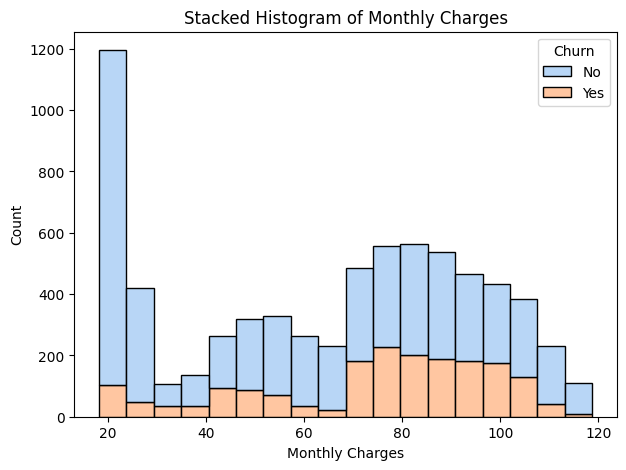

In [24]:
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

# plot
sns.histplot(data=raw_df_new, ax=ax, stat="count", multiple="stack",
             x="MonthlyCharges", kde=False,
             palette="pastel", hue="Churn",
             element="bars", legend=True)
ax.set_title("Stacked Histogram of Monthly Charges")
ax.set_xlabel("Monthly Charges")
ax.set_ylabel("Count")

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

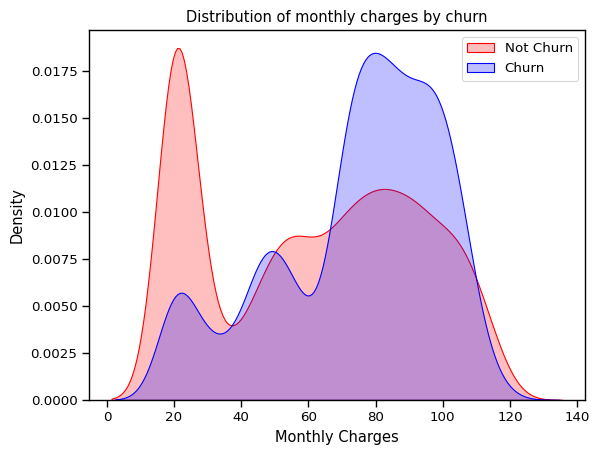

In [25]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(raw_df_new.MonthlyCharges[(raw_df_new["Churn"] == 'No') ],
                color="Red", fill = True);
ax = sns.kdeplot(raw_df_new.MonthlyCharges[(raw_df_new["Churn"] == 'Yes') ],
                ax =ax, color="Blue", fill= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn')

Judging from the two chart above, it could be seen that the higher monthly charges are, the most likely the customer will churn. This is of course make sense since people would opt to pay cheap price and stay with the cheaper subscription. Let's compare with the total charges

Text(0, 0.5, 'Count')

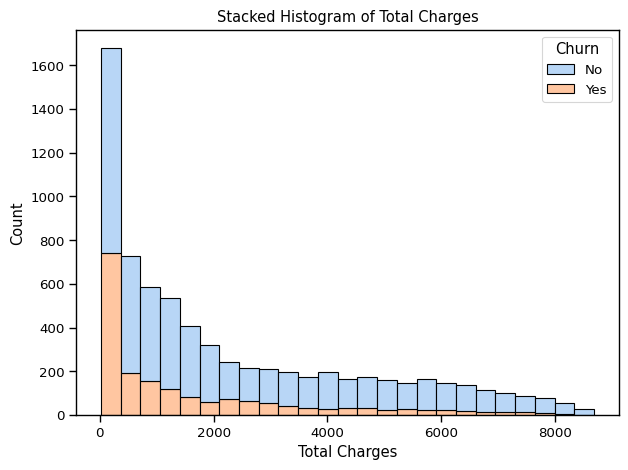

In [26]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

# plot
sns.histplot(data=raw_df_new, ax=ax, stat="count", multiple="stack",
             x="TotalCharges", kde=False,
             palette="pastel", hue="Churn",
             element="bars", legend=True)
ax.set_title("Stacked Histogram of Total Charges")
ax.set_xlabel("Total Charges")
ax.set_ylabel("Count")

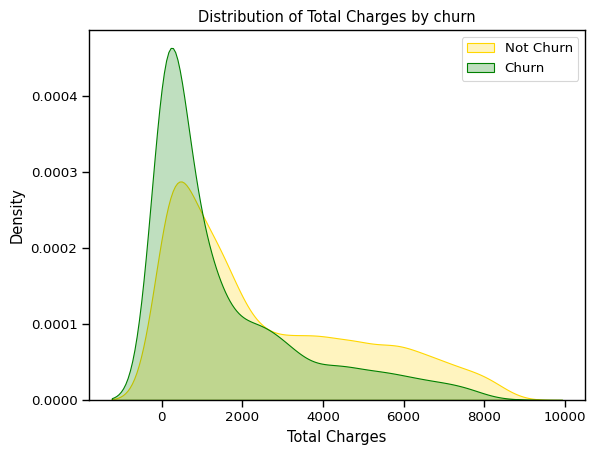

In [27]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(raw_df_new.TotalCharges[(raw_df_new["Churn"] == 'No') ],
                color="Gold", fill = True);
ax = sns.kdeplot(raw_df_new.TotalCharges[(raw_df_new["Churn"] == 'Yes') ],
                ax =ax, color="Green", fill= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of Total Charges by churn');

The trend between Not-Churn & Churned customers in total charges are similar. This perhaps caused by early churn that the customers are just started the subscription, and confirming the tenure chart that are customers who churns at early stage, making the company spending more capital for acquiring new customers.

### Preprocessing & Feature Engineering ###

Now, let's move on to the feature pre-processing! As we can see, we have 21 Features in which most likely we won't use all of them. So how can we whittle down the features into more manageable one? Firstly we could check the correlation between features given in the dataset. As rule of thumb we should aim to avoid having features that are highly correlated to each others, even though it may not contribute signicantly to the model's predictive power, it may increase the model complexities.

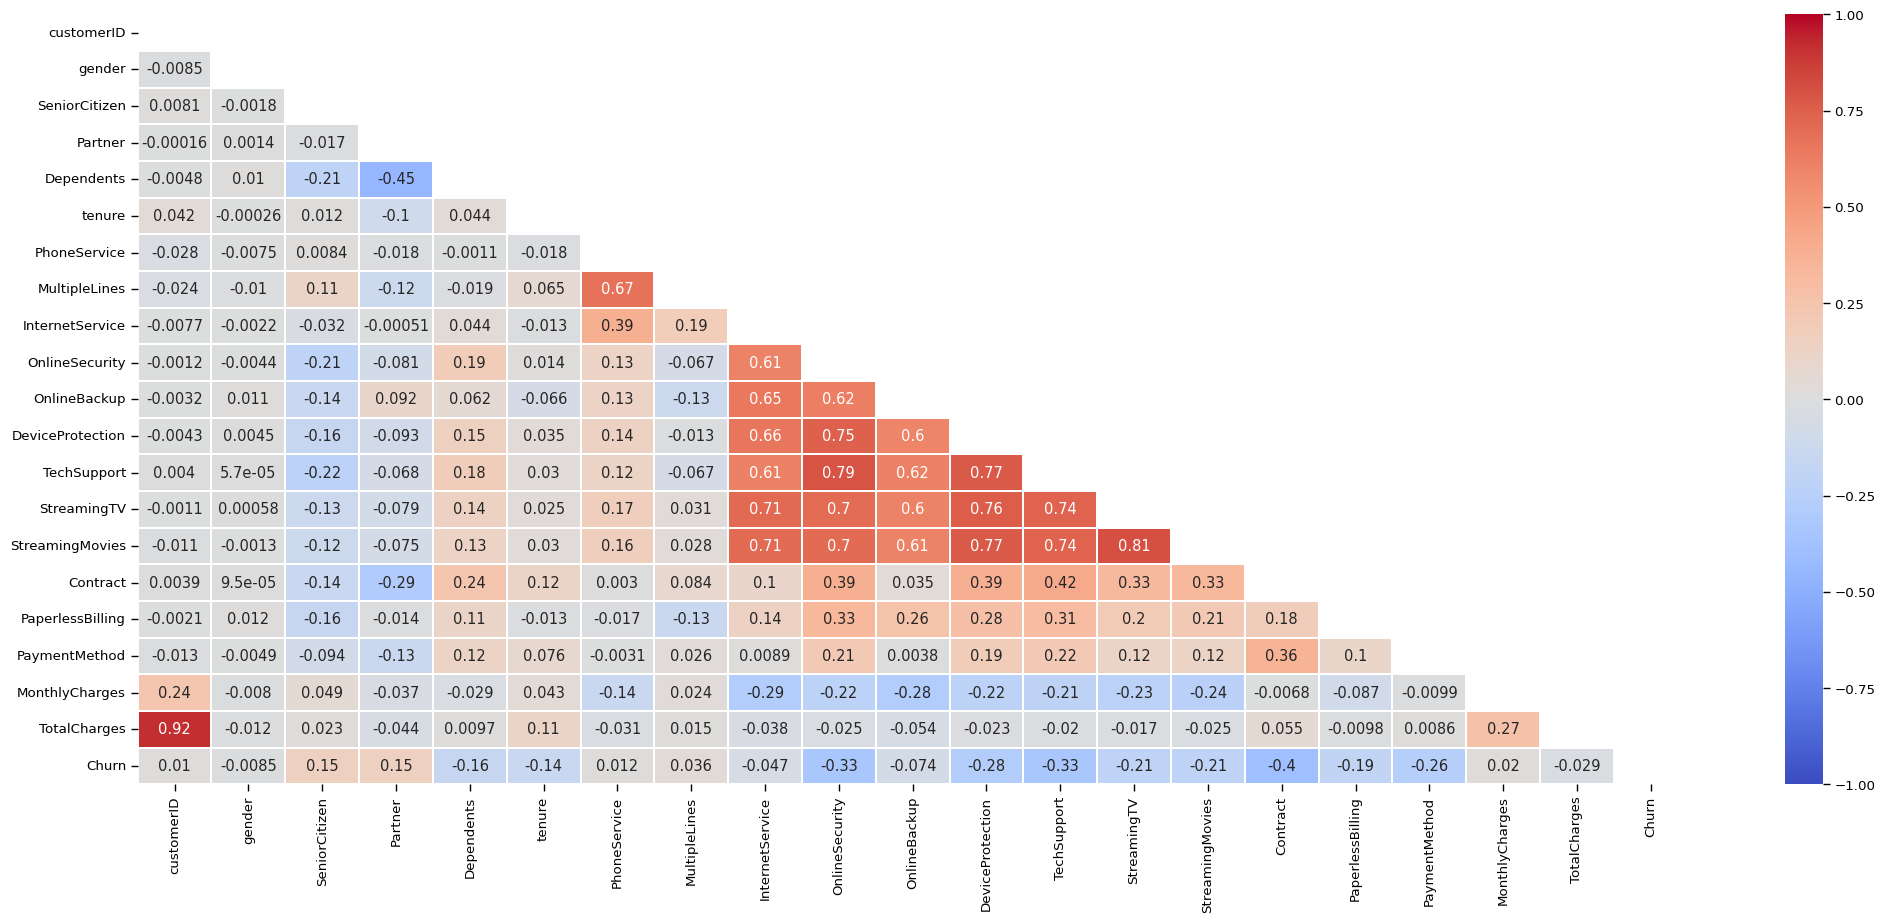

In [28]:
plt.figure(figsize=(25, 10))

corr = raw_df_new.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

As expected, the OnlineSecurity,OnlineBackup, DeviceProtection, TechSupport, Streaming TV & StreamingMovies are highly correlated between each other, as mentioned previously in the EDA Section. In this case, what I propose is to use the new feature that are aggregate of the 6 features mentioned. We shall call this feature "Services Subscribed". It is done by removing all but except one features that has high correlation with the target. In this case we will keep TechSupport.
Other than 6 features, One of the feature that had high correlation are MultipleLines vs PhoneServices. This made obvious since MultipleLines has the same information provided by PhoneServices, Hence we will remove the PhoneServices. We also have to remove CustomerID, since it gives nothing beneficial to the model.

In [29]:
pre_feat = raw_df_new.copy()
pre_feat = pre_feat.drop(['customerID', 'PhoneService'], axis =1 )

In [30]:
### replace the column value
for column in columns_to_replace:
    pre_feat[column].replace(dic, inplace=True)

In [31]:
pre_feat['ServicesSubscribed'] = pre_feat[columns_to_replace].sum(axis=1)
# replace -5994 value into -1 since 0 is already taken
pre_feat['ServicesSubscribed'] = pre_feat['ServicesSubscribed'].replace(-5994, -1)
pre_feat = pre_feat.drop(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'StreamingTV', 'StreamingMovies'], axis =1)

Next, we shall change the categorical data into numerical so our model could process it, the method is widely used and called label encoding. Using label encoder Scikit Library will help us to encode several columns. We first separate the columns we would like to encode from the original dataframe.

In [32]:
features_cat = ['gender', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
feat_df = pre_feat[features_cat].copy()

###separates the numerical column from categorical column
num_df=  pre_feat.drop(features_cat, axis =1)

In [33]:
le = preprocessing.LabelEncoder()
feat_df = feat_df.apply(le.fit_transform)

In [34]:
### Joining the the numerical data with the categorical feature
pre_feat_new = pd.concat([num_df, feat_df], axis =1)

Now, we almost have all columns ready to be modelled. However, for since feature PaymentMethod is not ordinal, we may perhaps have to use one-hot encoding to avoid misrepresentation of the feature.

In [35]:
feat_encoded = pd.get_dummies(pre_feat_new, columns=['PaymentMethod'], prefix=['PaymentMethod'])

One of the steps that could be done is of course is the standardization of the numerical column, namely 'Tenure', 'MonthlyCharges' & 'TotalCharges'. Nontheless, we need to notice that if we standardize the columns without separating the Training & Test set, we could introduce Data Leakage. Hence, we first separate the training & test set first.

We shall separate the test set by 30% of the total data

In [36]:
X = feat_encoded.drop(columns = ['Churn'])
y = feat_encoded['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state =101)

Let's see the distribution of each Numerical column to give us a glimpse of the range of the values

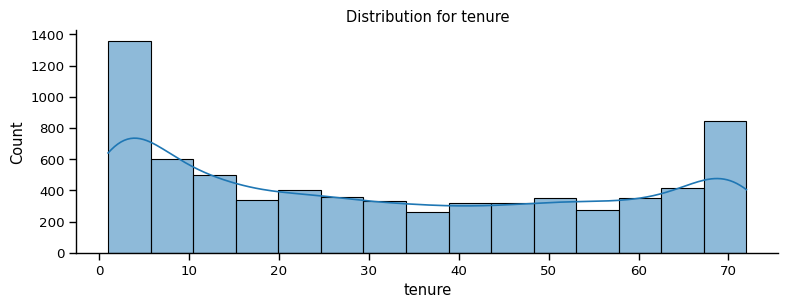

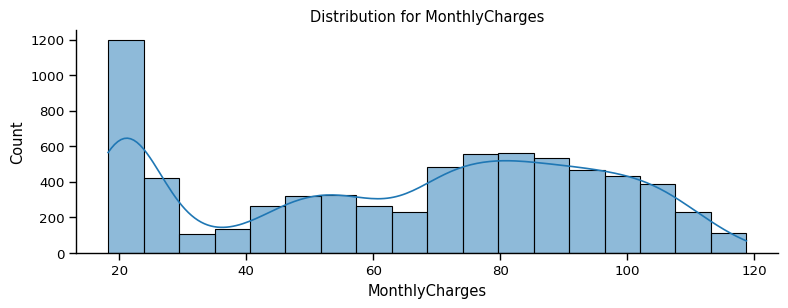

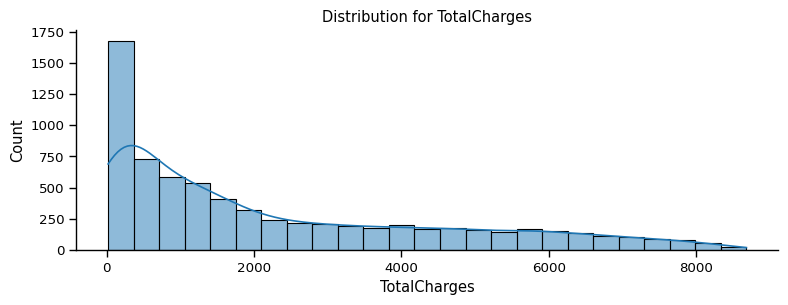

In [37]:
def displot(feature, frame, color='#1f77b4'):
    sns.displot(frame, x=feature, kde=True, height=3, aspect=8/3, color=color)
    plt.title("Distribution for {}".format(feature))
    plt.show()

num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols:
    displot(feat, X)

As we can see, the range between te values are quite large especially in TotalCharges Distribution. Now, let's see inf we standardize the numerical columnsw!

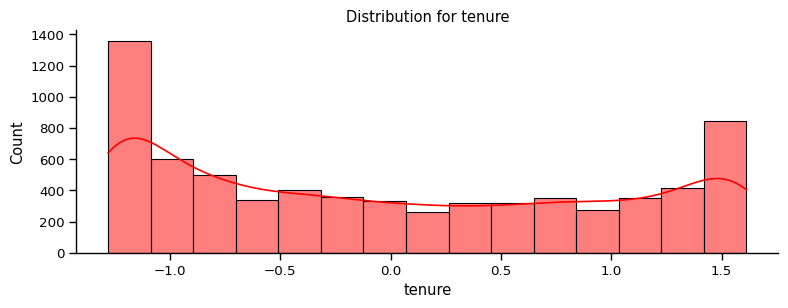

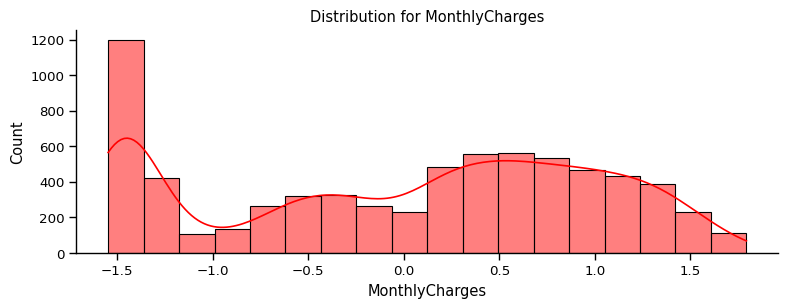

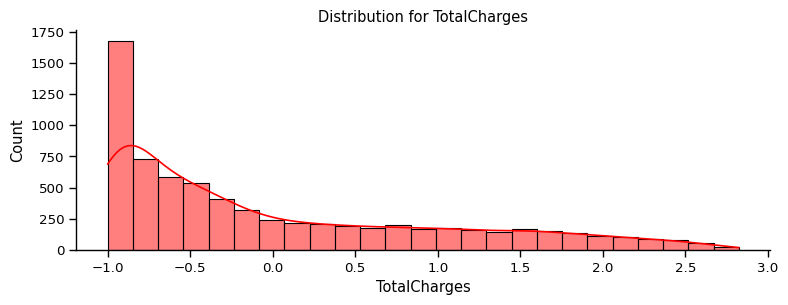

In [38]:
from sklearn.preprocessing import StandardScaler
df_std = pd.DataFrame(StandardScaler().fit_transform(X[num_cols].astype('float64')),
                       columns=num_cols)
for feat in num_cols: displot(feat, df_std, color='r')

let us not forget that we cannot use the standaridzed dataframe above since we have to standardize the test & training set separately to avoid data leakage.

In [39]:
scaler = StandardScaler()

X_train.loc[:, num_cols] = scaler.fit_transform(X_train.loc[:, num_cols])
X_test.loc[:, num_cols] = scaler.transform(X_test.loc[:, num_cols])

### Model Comparison ###

In here, we will start a baseline model before tweaking the model itself to compare with other methods we will implement. The models are Logistic Regression, Random Forest & XGBoost

#### A. Logistic Regression Model ###

In [42]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=500)
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.8028436018957346


At first, the result's accuracy is pretty good. However, to judge model's performance, we have to see the context of the output we want to achieve. Let's see other metrics to check.

In classification model output, we have to be familiar with the term True Positive, False Positive, True Negative, and False Negative.To make it easier for us, let's make a function for drawing confusion matrix!

In [43]:
def plot_confusion_matrix(cf_matrix):
    group_names = ['True (-)','False (+)','False (-)','True (+)']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

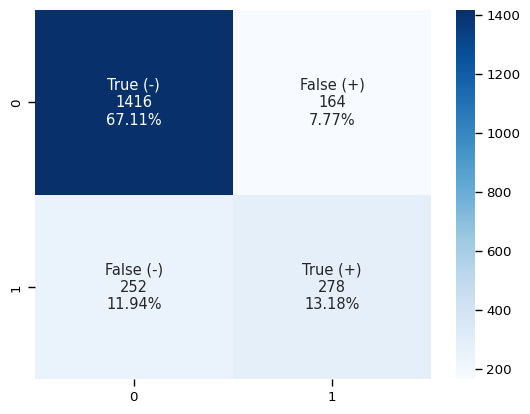

In [44]:
lr_pred = lr_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, lr_pred)
plot_confusion_matrix(cf_matrix)

We can see that the model predict's False Negative (Customer who actually churned but the model considers don't) is actually high, almost similar to True Positive. This is actually expected since the churned data we have is sparse and the dataset is imbalanced.

Another metric we could consider is the P-R Curve, The Precision-Recall Curve is the comparison between Precision & Recall, while the target of the model, different with the ROC Curve, is at the top right corner. While ROC itself is a good tool for evaluating binary decision model, it could present an overly optimistic view if there is a large skew in the class distribution[2]

Hence, we will move on to optimizing the PR Curve and also the model's Recall & Precision as our main metric.

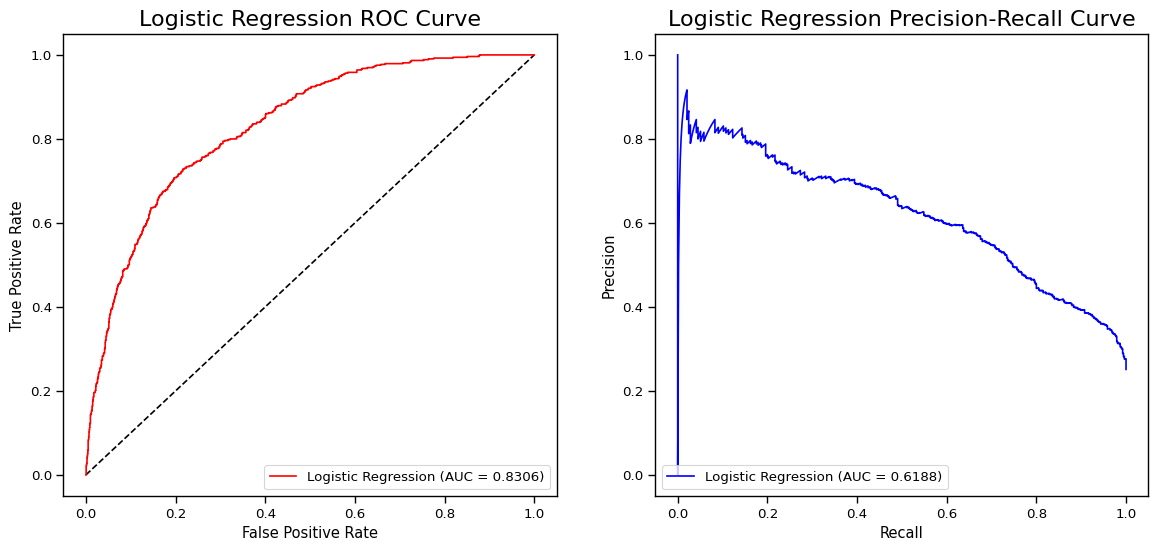

In [46]:
y_pred_lr = lr_model.predict_proba(X_test)[:, 1]

# Compute ROC values and AUC
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_lr)
lr_auc_score = roc_auc_score(y_test, y_pred_lr)

# Compute Precision-Recall values and AUC
lr_precision, lr_recall, lr_pr_thresholds = precision_recall_curve(y_test, y_pred_lr)
lr_pr_auc_score = auc(lr_recall, lr_precision)

# Create subplots for ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc_score:.4f})', color='r')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Logistic Regression ROC Curve', fontsize=16)
ax1.legend(loc='lower right')

# Plot Precision-Recall Curve
ax2.plot(lr_recall, lr_precision, label=f'Logistic Regression (AUC = {lr_pr_auc_score:.4f})', color='b')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Logistic Regression Precision-Recall Curve', fontsize=16)
ax2.legend(loc='lower left')

plt.show()

In [47]:
lr_pred = lr_model.predict(X_test)

recall_lr = recall_score(y_test, lr_pred)
precision_lr = precision_score(y_test, lr_pred)
print("Logistic Regression recall is :",round(recall_lr, 4))
print("Logistic Regression precision is :",round(precision_lr, 4))

Logistic Regression recall is : 0.5245
Logistic Regression precision is : 0.629


The Recall of the Logistic Regression model is unfortunately small, this is accurate from the confusion matrix as we can see that the Ratio between True Positive & False Negative is almost the same. While the precision means that the True Positive is higher than the False Positive. Let us move on to next model.

#### B. Random Forest ####

Now let's try Random Forest model!

In [48]:
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

rf_pred = model_rf.predict(X_test)

recall_rf = recall_score(y_test, rf_pred)
precision_rf = precision_score(y_test, rf_pred)
print("Random Forest recall is :",round(recall_rf,4))
print("Random Forest precision is :",round(precision_rf, 4))

Random Forest recall is : 0.517
Random Forest precision is : 0.6587


The recall of the random forest model is slightly worse than the Logistic Regression model, but the Precision is slightly better. This indicates that the False Negative is slightly higher, which means the Random Forest misses the churned customer slightly worse than the Logistic Regression Model. Let's plot the ROC & PR curve and its Area Under:

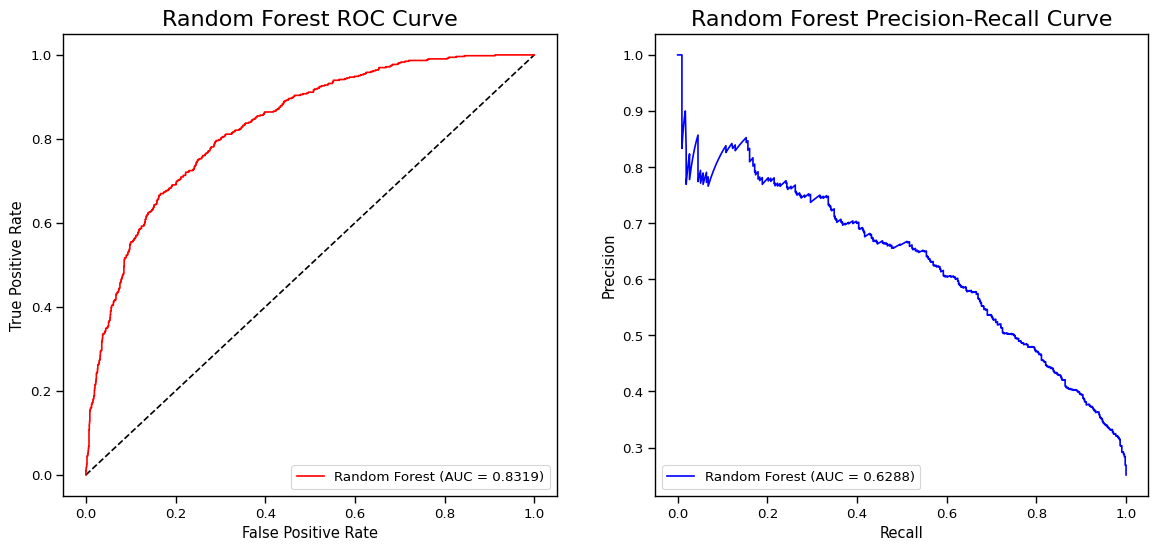

In [49]:
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]

# Compute ROC values and AUC
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_pred_rf)
rf_auc_score = roc_auc_score(y_test, y_pred_rf)

# Compute Precision-Recall values and AUC
rf_precision, rf_recall, rf_pr_thresholds = precision_recall_curve(y_test, y_pred_rf)
rf_pr_auc_score = auc(rf_recall, rf_precision)

# Create subplots for ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc_score:.4f})', color='r')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Random Forest ROC Curve', fontsize=16)
ax1.legend(loc='lower right')

# Plot Precision-Recall Curve
ax2.plot(rf_recall, rf_precision, label=f'Random Forest (AUC = {rf_pr_auc_score:.4f})', color='b')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Random Forest Precision-Recall Curve', fontsize=16)
ax2.legend(loc='lower left')

plt.show()


Even though its Area Under P-R Curve is slightly better than the Logistic Regression Model, it is due to its Precision being higher than the previous model. This does not indicates that the Random Forest Model is a better model, it is just slightly better at reducing False Positive.
Let's check other model, namely XGBoost.

#### C. XGBoost Model ####

Let's try the XGBoost Model

In [50]:
xg_model = XGBClassifier(use_label_encoder =False, eval_metric = 'auc')
xg_model.fit(X_train, y_train)
xg_pred = xg_model.predict(X_test)

recall_xg = recall_score(y_test, xg_pred)
precision_xg = precision_score(y_test, xg_pred)
print("XGBoost recall is :",round(recall_xg, 4))
print("XGBoost precision is :",round(precision_xg, 4))

XGBoost recall is : 0.5189
XGBoost precision is : 0.5777


By far, this is the worst result of the models compared to the prior two. The Recall itself just means that it missed (almost) half of the churned customers. While the precision result itself means it falsely identify remaining customers worse than other two model. Let's check the AUROC & AU P-R Curve:

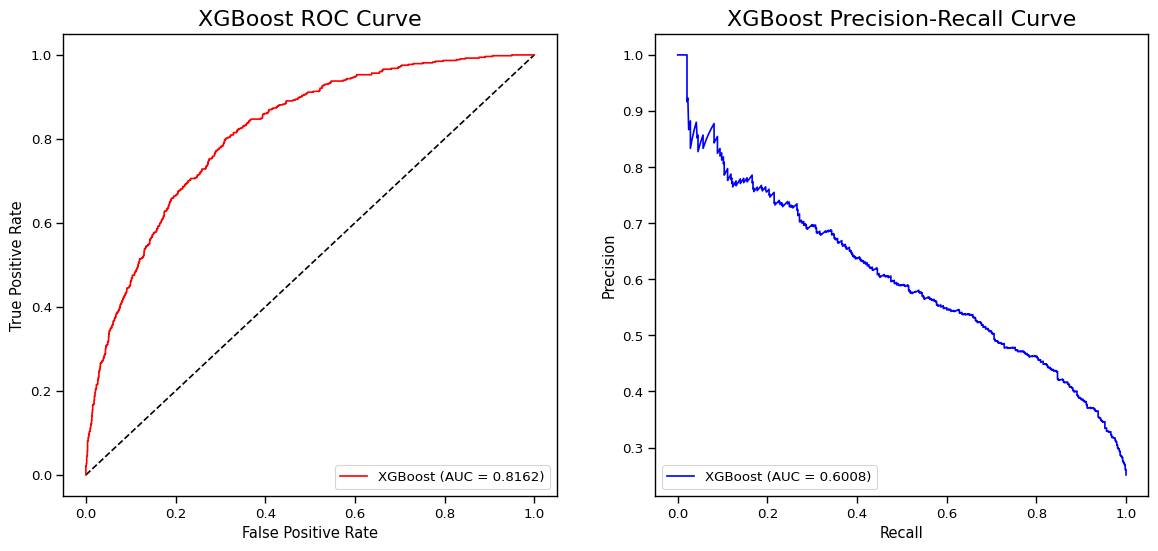

In [51]:
# Assuming y_pred_lr and lr_model are already defined
y_pred_prob = xg_model.predict_proba(X_test)[:, 1]

# Compute ROC values and AUC
xg_fpr, xg_tpr, xg_thresholds = roc_curve(y_test, y_pred_prob)
xg_auc_score = roc_auc_score(y_test, y_pred_prob)

# Compute Precision-Recall values and AUC
xg_precision, xg_recall, xg_pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
xg_pr_auc_score = auc(xg_recall, xg_precision)

# Create subplots for ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(xg_fpr, xg_tpr, label=f'XGBoost (AUC = {xg_auc_score:.4f})', color='r')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('XGBoost ROC Curve', fontsize=16)
ax1.legend(loc='lower right')

# Plot Precision-Recall Curve
ax2.plot(xg_recall, xg_precision, label=f'XGBoost (AUC = {xg_pr_auc_score:.4f})', color='b')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('XGBoost Precision-Recall Curve', fontsize=16)
ax2.legend(loc='lower left')

plt.show()

As expected, even the AUROC is worse than both model, but the model's performance could be improved with tweaking its hyperparameters. However, hyperparameter tweaking is out of the scope of this article, hence in the next section we would not include XGBoost.

### Oversampling vs Undersampling ###

Based on EDA & Baseline model Comparison Section above, it could be seen that the dataset has class imbalance, with around 1:3 Ratio, the customers who churned are much less than the one who stayed. This causes the model having hard time to predict the churned class, as previously seen in the recall result of the models above.

One of the method to compensate such poor result due to imbalanced dataset is to either removing the majority class randomly until it reaches the same amount of minority class (Undersampling), or to generate more of the minority sample until it reaches equality (Oversampling).

We will first try to user Oversampling Method

#### A. Oversampling ####

We will try to use Naive random over-sampling, which generate new samples by randomly sampling with replacement the existing samples.

In [52]:
ros = RandomOverSampler(random_state = 42)
X_resample, y_resample = ros.fit_resample(X_train, y_train)

In [53]:
unique, frequency = np.unique(y_train, return_counts = True)
count = np.asarray((unique, frequency))
print(count)

[[   0    1]
 [3583 1339]]


In [54]:
unique, frequency = np.unique(y_resample, return_counts = True)
count = np.asarray((unique, frequency))
print(count)

[[   0    1]
 [3583 3583]]


It shows that after ovesampling, the "1" class has the same number as the "0" class from previously only 1339. Let's try the new data to the Logistic Regression Model & Random Forest!

##### A.1 Logistic Regression with Oversampling #####

In [55]:
lr_ros_model = LogisticRegression(solver='lbfgs', max_iter=700)
lr_ros_model.fit(X_resample,y_resample)

lr_ros_pred = lr_ros_model.predict(X_test)

recall_ros_lr = recall_score(y_test, lr_ros_pred)
precision_ros_lr = precision_score(y_test, lr_ros_pred)
print("Logistic Regression Oversampling recall is :",round(recall_ros_lr, 4))
print("Logistic Regression Oversampling precision is :",round(precision_ros_lr, 4))

Logistic Regression Oversampling recall is : 0.7604
Logistic Regression Oversampling precision is : 0.4775


The ROS (Random OverSampling) Logistic Regression Recall is much better than the baseline model, this means that the rate of False Negative is much lower, indicating the model is better capturing the customers who actually churned ( True Positive). However, this comes at a cost of huge loss of precision, increasing the model's False Positive, this is expected since the churned dataset is balanced. Making the model's retrieval at higher rate than the baseline model.

Let's see the AUROC & AU P-R Curve and its comparison with Baseline Model:

In [56]:
def plot_model_comparison(baseline_model, comparison_model,comparison_type, X_test, y_test, model_type):
    # Predictions for baseline model
    y_pred_baseline = baseline_model.predict_proba(X_test)[:, 1]

    # Predictions for oversampled model
    y_pred_comparison = comparison_model.predict_proba(X_test)[:, 1]

    # Compute baseline ROC and PR values and AUCs
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline)
    auc_baseline = roc_auc_score(y_test, y_pred_baseline)
    precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_baseline)
    pr_auc_baseline = auc(recall_baseline, precision_baseline)

    # Compute oversampled ROC and PR values and AUCs
    fpr_comparison, tpr_comparison, _ = roc_curve(y_test, y_pred_comparison)
    auc_comparison = roc_auc_score(y_test, y_pred_comparison)
    precision_comparison, recall_comparison, _ = precision_recall_curve(y_test, y_pred_comparison)
    pr_auc_comparison = auc(recall_comparison, precision_comparison)

    # Create subplots for ROC and Precision-Recall curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot ROC Curves
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {auc_baseline:.4f})', color='r')
    ax1.plot(fpr_comparison, tpr_comparison, label=f'{comparison_type} (AUC = {auc_comparison:.4f})', color='b')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_type} ROC Curve Comparison', fontsize=16)
    ax1.legend(loc='lower right')

    # Plot Precision-Recall Curves
    ax2.plot(recall_baseline, precision_baseline, label=f'Baseline (AUC = {pr_auc_baseline:.4f})', color='r')
    ax2.plot(recall_comparison, precision_comparison, label=f'{comparison_type} (AUC = {pr_auc_comparison:.4f})', color='b')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_type} Precision-Recall Curve Comparison', fontsize=16)
    ax2.legend(loc='lower left')

    plt.show()

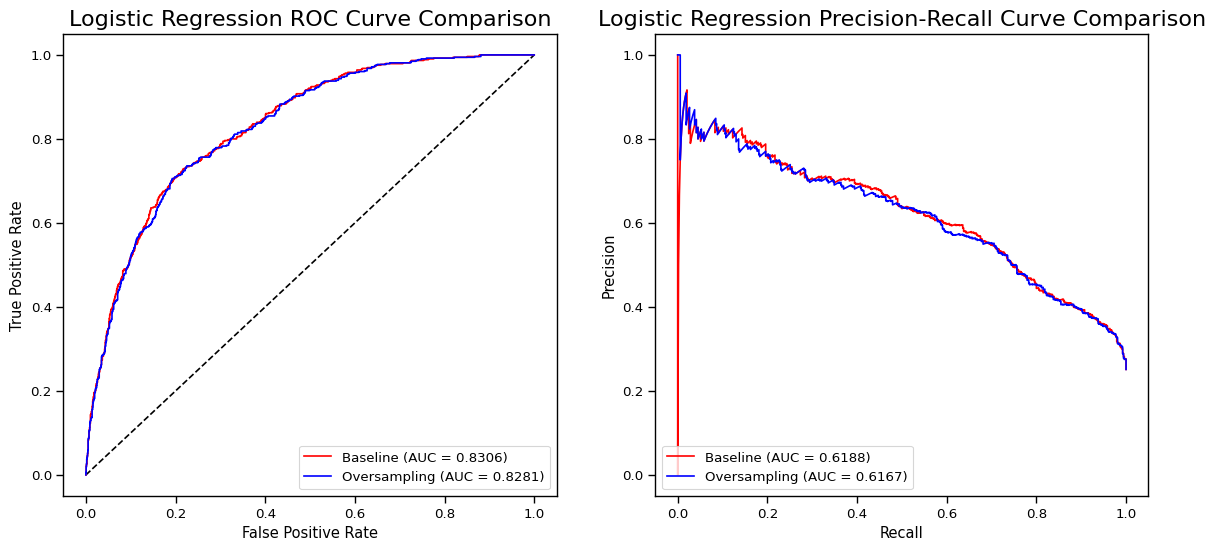

In [57]:
plot_model_comparison(lr_model, lr_ros_model,'Oversampling', X_test, y_test, "Logistic Regression")

Unfortunately, comparing the AUC of both curves to the baseline model resulted in lower AUC, even though it is very minimal. Since the goal of the model is also to increase Recall, sacrificing the Precision value is just the price we have to pay. Let's try the Random Forest model.

##### A.2 Random Forest with Oversampling #####

In [58]:
model_ros_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_ros_rf.fit(X_resample, y_resample)

rf_ros_pred = model_ros_rf.predict(X_test)


recall_ros_rf = recall_score(y_test, rf_ros_pred)
precision_ros_rf = precision_score(y_test, rf_ros_pred)
print("Random Forest Oversampling recall is :",round(recall_ros_rf, 4))
print("Random Forest Oversampling precision is :",round(precision_ros_rf, 4))

Random Forest Oversampling recall is : 0.7472
Random Forest Oversampling precision is : 0.4975


Similar with the Oversampled Logistic Regression Model, the Random Forest oversampled model fare better than its baseline in terms of recall. Yet, compared to the Oversampled LR Model, the recall is less but its precision is slightly higher. As for the AUROC & AU P-R Curve:

In [59]:
def plot_confusion_matrices(cf_matrix1, cf_matrix2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, cf_matrix, title in zip(axes, [cf_matrix1, cf_matrix2], ['ROS Logistic Regression', 'ROS Random Forest']):
        group_names = ['True (-)','False (+)','False (-)','True (+)']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)

        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)
        ax.set_title(title)

    plt.show()


In [60]:
rf_ros_matrix = confusion_matrix(y_test, rf_ros_pred)
lr_ros_matrix = confusion_matrix(y_test, lr_ros_pred)

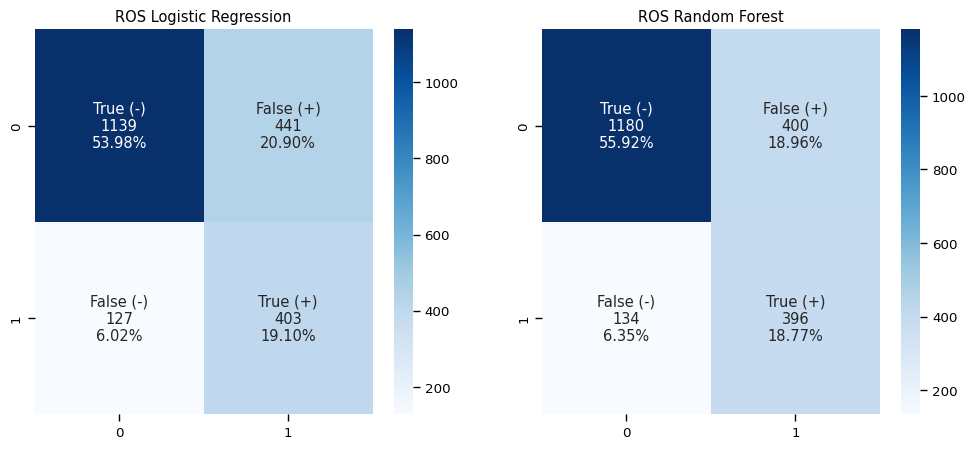

In [61]:
plot_confusion_matrices(lr_ros_matrix,rf_ros_matrix)

It could be seen that since the ROS Logistic Regression's recall is better than the ROS Random Forest, it is also reflected at the confusion matrix as well. The TP of the ROS Logistic Regression is better and simultaneously the FN is also lower, making it clear why the Recall of the ROS logistic Regression is better than the ROS Random Forest's.

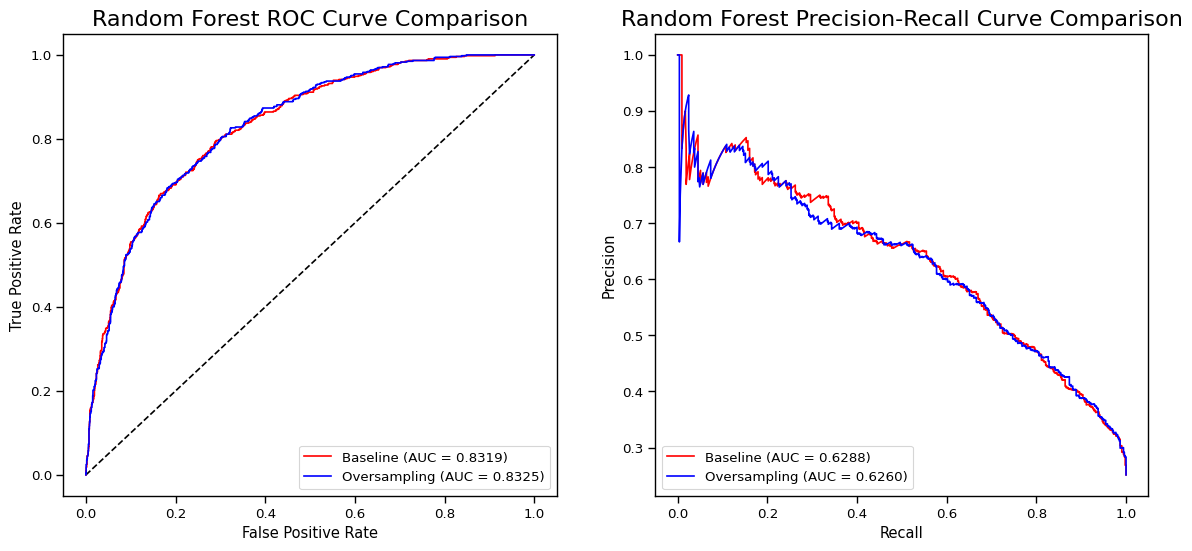

In [62]:
plot_model_comparison(model_rf, model_ros_rf,'Oversampling', X_test, y_test, "Random Forest")

The Oversampled Random Forest's AUROC is slightly better than the baseline model. This is of course a good news, let's try another method in the next section.

#### B. Undersampling ####

While oversampling works by generating more of the minority sample, making the dataset class balanced, undersampling simply just remove the majority class randomly so the dataset will have the same amount between classess. This method is usually unfavoured due to the fact that we have to remove data that are usually painstacking to collect.

Fortunately, our dataset has ample of majority class (relatively), so cutting them down to be equal to the minority class should not pose a major issue.

In [63]:
rus = RandomUnderSampler(random_state=42, sampling_strategy= 'majority')
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [64]:
unique, frequency = np.unique(y_train, return_counts = True)
count = np.asarray((unique, frequency))
print(count)

[[   0    1]
 [3583 1339]]


In [65]:
unique, frequency = np.unique(y_rus, return_counts = True)
count = np.asarray((unique, frequency))
print(count)

[[   0    1]
 [1339 1339]]


It is clear that we remove the "0" class more than half until they are equal to the minority class!

##### B.1 Logistic Regression with Undersampling #####

In [66]:
lr_rus_model = LogisticRegression(solver='lbfgs', max_iter=500)
lr_rus_model.fit(X_rus,y_rus)

lr_rus_pred = lr_rus_model.predict(X_test)

recall_rus_lr = recall_score(y_test, lr_rus_pred)
precision_rus_lr = precision_score(y_test, lr_rus_pred)
print("Logistic Regression Undersampling recall is :",round(recall_rus_lr, 4))
print("Logistic Regression Undersampling precision is :",round(precision_rus_lr, 4))

Logistic Regression Undersampling recall is : 0.7679
Logistic Regression Undersampling precision is : 0.4755


Comparing it to the Oversampled LR model, the recall is precisely the same, much better than the baseline. Furthermore, the Undersampling's precision is slightly above the Oversampling model. Now let's compare its AUROC & AU P-R Curve

In [67]:
def plot_model_comparison(baseline_model, oversampled_model, undersampled_model, X_test, y_test, model_type):
    # Predictions for baseline model
    y_pred_baseline = baseline_model.predict_proba(X_test)[:, 1]

    # Predictions for oversampled model
    y_pred_oversampled = oversampled_model.predict_proba(X_test)[:, 1]

    # Predictions for undersampled model
    y_pred_undersampled = undersampled_model.predict_proba(X_test)[:, 1]

    # Compute baseline ROC and PR values and AUCs
    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline)
    auc_baseline = roc_auc_score(y_test, y_pred_baseline)
    precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_baseline)
    pr_auc_baseline = auc(recall_baseline, precision_baseline)

    # Compute oversampled ROC and PR values and AUCs
    fpr_oversampled, tpr_oversampled, _ = roc_curve(y_test, y_pred_oversampled)
    auc_oversampled = roc_auc_score(y_test, y_pred_oversampled)
    precision_oversampled, recall_oversampled, _ = precision_recall_curve(y_test, y_pred_oversampled)
    pr_auc_oversampled = auc(recall_oversampled, precision_oversampled)

    # Compute undersampled ROC and PR values and AUCs
    fpr_undersampled, tpr_undersampled, _ = roc_curve(y_test, y_pred_undersampled)
    auc_undersampled = roc_auc_score(y_test, y_pred_undersampled)
    precision_undersampled, recall_undersampled, _ = precision_recall_curve(y_test, y_pred_undersampled)
    pr_auc_undersampled = auc(recall_undersampled, precision_undersampled)

    # Create subplots for ROC and Precision-Recall curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot ROC Curves
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {auc_baseline:.4f})', color='r')
    ax1.plot(fpr_oversampled, tpr_oversampled, label=f'Oversampled (AUC = {auc_oversampled:.4f})', color='b')
    ax1.plot(fpr_undersampled, tpr_undersampled, label=f'Undersampled (AUC = {auc_undersampled:.4f})', color='g')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_type} ROC Curve Comparison', fontsize=16)
    ax1.legend(loc='lower right')

    # Plot Precision-Recall Curves
    ax2.plot(recall_baseline, precision_baseline, label=f'Baseline (AUC = {pr_auc_baseline:.4f})', color='r')
    ax2.plot(recall_oversampled, precision_oversampled, label=f'Oversampled (AUC = {pr_auc_oversampled:.4f})', color='b')
    ax2.plot(recall_undersampled, precision_undersampled, label=f'Undersampled (AUC = {pr_auc_undersampled:.4f})', color='g')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_type} Precision-Recall Curve Comparison', fontsize=16)
    ax2.legend(loc='lower left')

    plt.show()

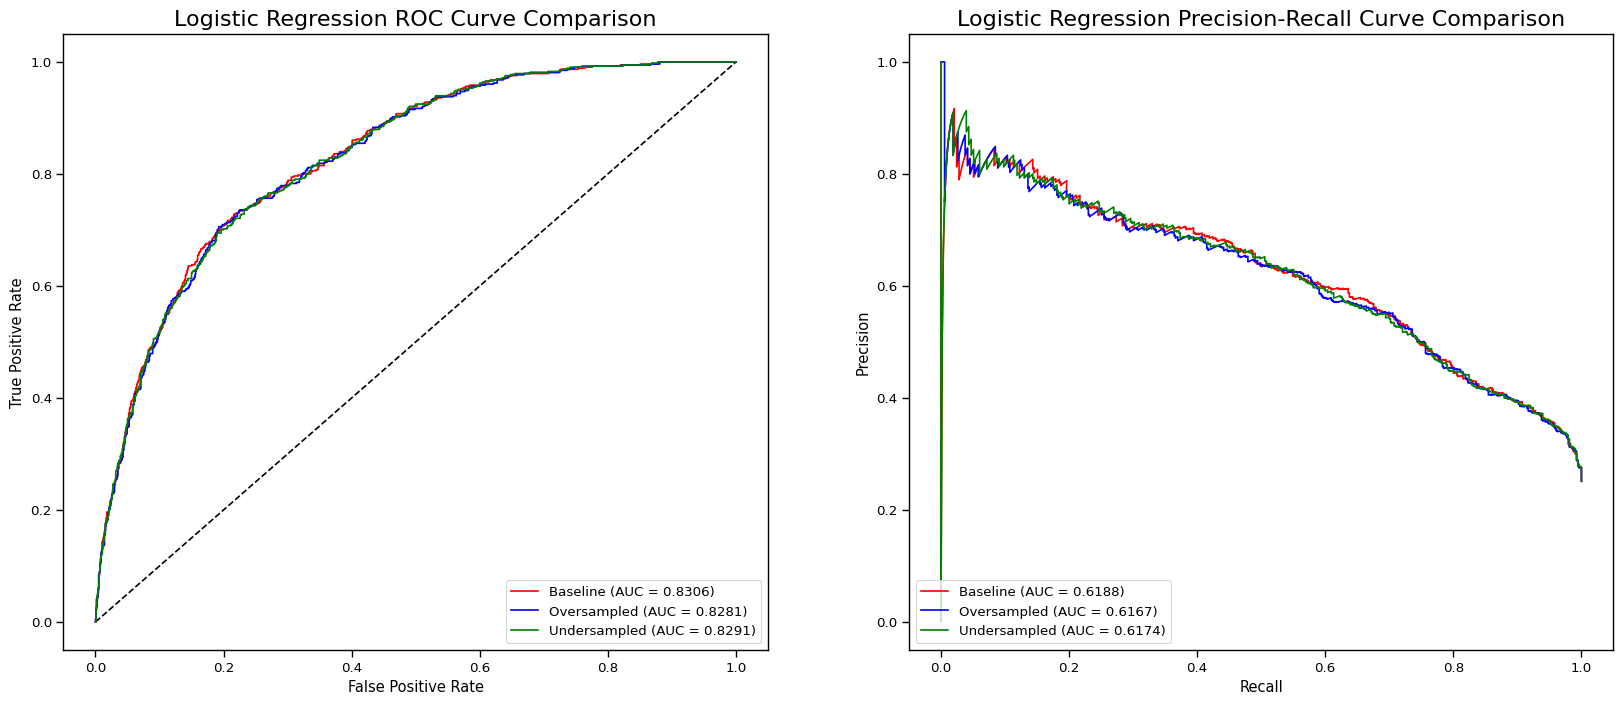

In [68]:
plot_model_comparison(lr_model, lr_ros_model, lr_rus_model, X_test, y_test, "Logistic Regression")

As mentioned before, the AUC of the P-R Curve is actually the same with the Oversampled and unfortunately, it has lower AUC than the Baseline model too. Let's see for the Random Forest model.

##### B.2 Random Forest with Undersampling #####

In [69]:
model_rus_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_rus_rf.fit(X_rus, y_rus)

rf_rus_pred = model_rus_rf.predict(X_test)

recall_rus_rf = recall_score(y_test, rf_rus_pred)
precision_rus_rf = precision_score(y_test, rf_rus_pred)
print("Random Forest Undersampling recall is :",round(recall_rus_rf, 4))
print("Random Forest Undersampling precision is :",round(precision_rus_rf, 4))

Random Forest Undersampling recall is : 0.7528
Random Forest Undersampling precision is : 0.4926


Apparently, the recall is higher than the Oversampled Random Forest, albeit still lower than both Undersampled and Oversampled Logistic Regression model. Let's check its AUROC & AU P-R Curve:

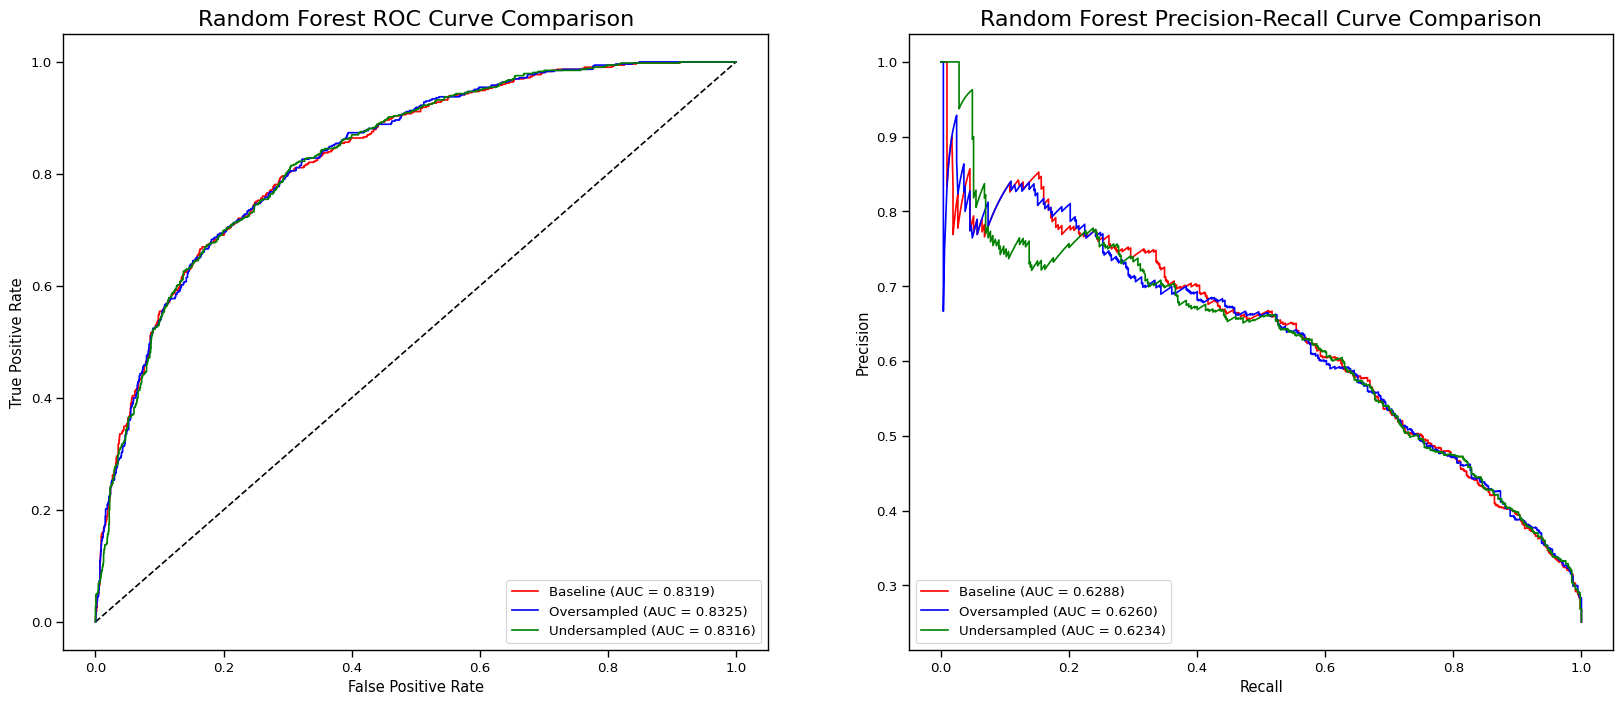

In [70]:
plot_model_comparison(model_rf, model_ros_rf, model_rus_rf, X_test, y_test, "Random Forest")

Compared to the Oversampled AUROC & AU P-R Curve, its area is slightly lower. Furthermore, in contrast to the baseline model, the area itself is lesser. This of course happened the same reason with the oversampled model, it increases the model's recall but greatly decreases its precision. Let's compare all oversampled & undersampled model's Confusion Matrix.

In [71]:
def plot_confusion_matrices(cf_matrix_lr_ros, cf_matrix_lr_rus, cf_matrix_rf_ros, cf_matrix_rf_rus):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Titles for the subplots
    titles = [
        'Logistic Regression (ROS)',
        'Random Forest (ROS)',
        'Logistic Regression (RUS)',
        'Random Forest (RUS)'
    ]

    # Confusion matrices
    cf_matrices = [
        cf_matrix_lr_ros,
        cf_matrix_rf_ros,
        cf_matrix_lr_rus,
        cf_matrix_rf_rus
    ]

    for ax, cf_matrix, title in zip(axes.flatten(), cf_matrices, titles):
        group_names = ['True (-)','False (+)','False (-)','True (+)']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)

        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [72]:
lr_rus_matrix = confusion_matrix(y_test, lr_rus_pred)
rf_rus_matrix = confusion_matrix(y_test, rf_rus_pred)

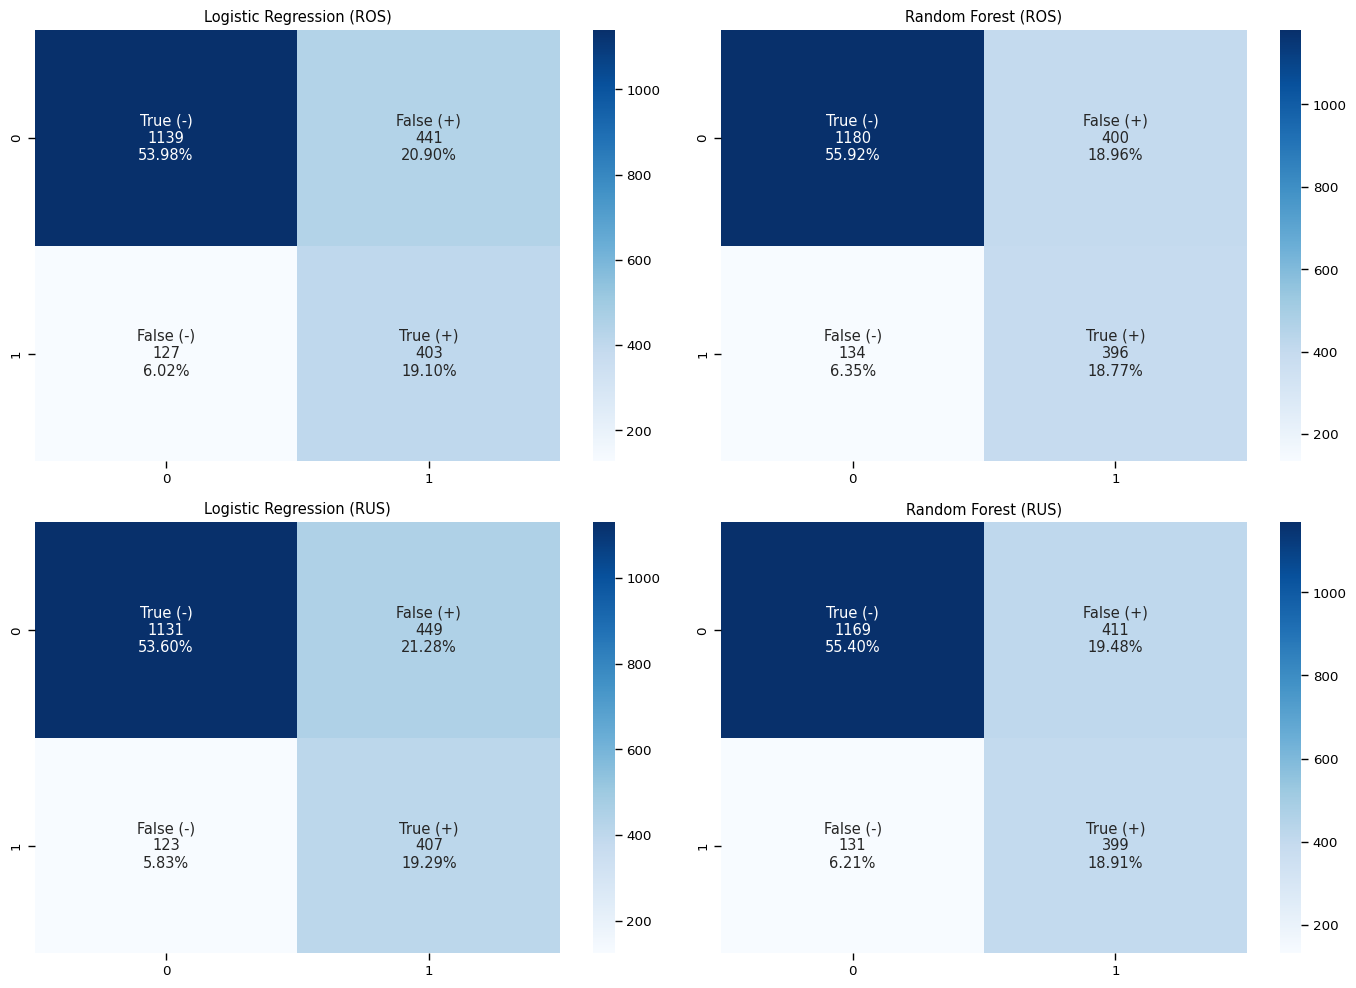

In [73]:
plot_confusion_matrices(lr_ros_matrix, lr_rus_matrix,rf_ros_matrix, rf_rus_matrix)

In [74]:
cf_summary = pd.DataFrame([['Recall', recall_lr, recall_ros_lr,recall_rus_lr, recall_rf, recall_ros_rf,recall_rus_rf],
                     ['Precision', precision_lr,precision_ros_lr,precision_rus_lr, precision_rf,precision_ros_rf,precision_rus_rf]],
                    columns=['Score', 'Baseline LR', 'Oversampled LR', 'Undersampled LR', 'Baseline RF', 'Oversampled RF', 'Undersampled RF'])

cf_summary.set_index('Score', inplace=True)


In [75]:
cf_summary

,Baseline LR,Oversampled LR,Undersampled LR,Baseline RF,Oversampled RF,Undersampled RF
Score,,,,,,
Recall,0.524528,0.760377,0.767925,0.516981,0.747170,0.752830
Precision,0.628959,0.477488,0.475467,0.658654,0.497487,0.492593


Interestingly, the TP & FP of both Undersampled Logistic Regression model & Random Forest model were increased compared to the oversampled model. It also decreases its False negative, hence increasing its recall score at a sacrifice of increasing FP of the model. Compared to all, in terms of recall & precision score, the Undersampled Logistic Regression Model is the winner.

#### C. Combining Oversampling with Undersampling ####

After trying to improve the model by either undersampling or oversampling, why not try both? In this section we will try to oversample the minority class while simultaneously removing the majority class. The number of the train dataset hence will be in the middle threshold of the undersampling & oversampling.
Firstly we remove the majority class (Undersample).

In [76]:
unique, counts = np.unique(y_train, return_counts=True)
minority_class_count = min(counts)
majority_class_label = unique[np.argmax(counts)]

In [77]:
under_sampler = RandomUnderSampler(sampling_strategy={majority_class_label: 2 * minority_class_count}, random_state=42)

In [78]:
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

In [79]:
unique, frequency = np.unique(y_train, return_counts = True)
count = np.asarray((unique, frequency))
print(count)

[[   0    1]
 [3583 1339]]


In [80]:
unique, frequency = np.unique(y_under, return_counts = True)
count = np.asarray((unique, frequency))
print(count)

[[   0    1]
 [2678 1339]]


In [81]:
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

In [82]:
X_resampled, y_resampled = over_sampler.fit_resample(X_under, y_under)

In [83]:
res_unique, res_frequency = np.unique(y_resampled, return_counts = True)
res_count = np.asarray((res_unique, res_frequency))
print(res_count)

[[   0    1]
 [2678 2678]]


As we can see, the number of the majority and minority class is equal, by reaching around the middle point of oversampling & undersampling. Let's see the Logistic Regression & Random Forest results for the new data:

##### C.1 Logistic Regression with Both Sampling #####

In [84]:
lr_rous_model = LogisticRegression(solver='lbfgs', max_iter=500)
lr_rous_model.fit(X_resampled,y_resampled)

lr_rous_pred = lr_rous_model.predict(X_test)

recall_rous_lr = recall_score(y_test, lr_rous_pred)
precision_rous_lr = precision_score(y_test, lr_rous_pred)
print("Logistic Regression Undersampling & Oversampling recall is :",round(recall_rous_lr, 4))
print("Logistic Regression Undersampling & Oversampling precision is :",round(precision_rous_lr, 4))

Logistic Regression Undersampling & Oversampling recall is : 0.7623
Logistic Regression Undersampling & Oversampling precision is : 0.477


As it happens, both the recall & precision of the Oversampling & Undersampling Logistic Regression Model perform worse than the Undersampling or the Oversampling model. Let's check its P-R Curve

In [85]:
def plot_model_comparison(baseline_model, oversampled_model, undersampled_model, both_model, X_test, y_test, model_type):
    # Predictions for baseline model
    y_pred_baseline = baseline_model.predict_proba(X_test)[:, 1]

    # Predictions for oversampled model
    y_pred_oversampled = oversampled_model.predict_proba(X_test)[:, 1]

    # Predictions for undersampled model
    y_pred_undersampled = undersampled_model.predict_proba(X_test)[:, 1]

    # Predictions for both oversampled and undersampled model
    y_pred_both = both_model.predict_proba(X_test)[:, 1]

    # Compute baseline PR values and AUCs
    precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_baseline)
    pr_auc_baseline = auc(recall_baseline, precision_baseline)

    # Compute oversampled PR values and AUCs
    precision_oversampled, recall_oversampled, _ = precision_recall_curve(y_test, y_pred_oversampled)
    pr_auc_oversampled = auc(recall_oversampled, precision_oversampled)

    # Compute undersampled PR values and AUCs
    precision_undersampled, recall_undersampled, _ = precision_recall_curve(y_test, y_pred_undersampled)
    pr_auc_undersampled = auc(recall_undersampled, precision_undersampled)

    # Compute both oversampled and undersampled PR values and AUCs
    precision_both, recall_both, _ = precision_recall_curve(y_test, y_pred_both)
    pr_auc_both = auc(recall_both, precision_both)

    # Create a subplot for Precision-Recall curves
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Precision-Recall Curves
    ax.plot(recall_baseline, precision_baseline, label=f'Baseline (AUC = {pr_auc_baseline:.4f})', color='r')
    ax.plot(recall_oversampled, precision_oversampled, label=f'Oversampled (AUC = {pr_auc_oversampled:.4f})', color='b')
    ax.plot(recall_undersampled, precision_undersampled, label=f'Undersampled (AUC = {pr_auc_undersampled:.4f})', color='g')
    ax.plot(recall_both, precision_both, label=f'Both (AUC = {pr_auc_both:.4f})', color='m')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{model_type} Precision-Recall Curve Comparison', fontsize=16)
    ax.legend(loc='lower left')

    plt.show()


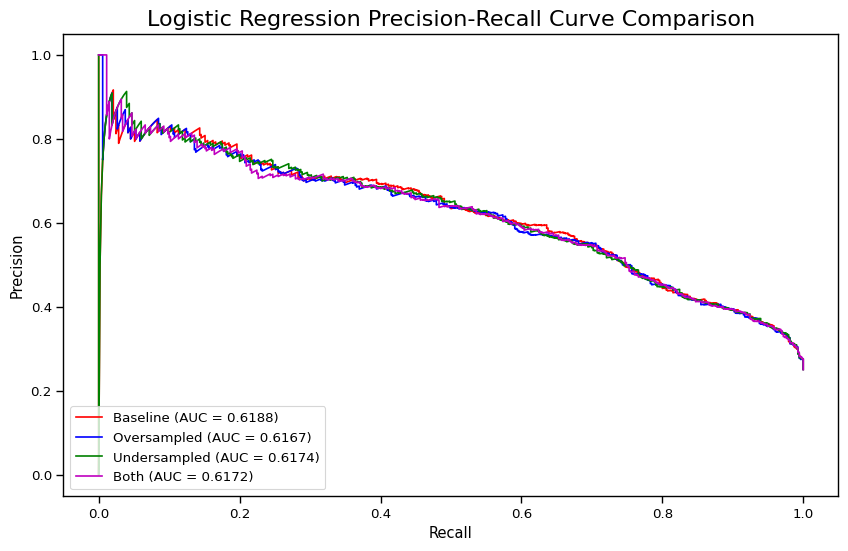

In [86]:
plot_model_comparison(lr_model, lr_ros_model, lr_rus_model, lr_rous_model, X_test, y_test, "Logistic Regression")

Using both Undersampling & Oversampling method for the Area Under P-R Curve actually puts its value in between Undersampling & Oversampling, which is not surprising and expected. Let's see if the Random Forest model fare better.

##### C.2 Random Forest with Both Sampling #####

In [87]:
model_rous_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_rous_rf.fit(X_resampled, y_resampled)

# Make predictions
rf_rous_pred = model_rous_rf.predict(X_test)

recall_rous_rf = recall_score(y_test, rf_rous_pred)
precision_rous_rf = precision_score(y_test, lr_rous_pred)
print("Random Forest Undersampling & Oversampling recall is :",round(recall_rous_rf, 4))
print("Random Forest Undersampling & Oversampling precision is :",round(precision_rous_rf, 4))

Random Forest Undersampling & Oversampling recall is : 0.7415
Random Forest Undersampling & Oversampling precision is : 0.477


Similar to the Logistic Regression model, although it's better than the baseline model, it is actually worse compared to both Undersampling & Oversampling model. Both its recall and precision are lower than previous models. Let's draw its P-R curve and check its Area Under Curve.

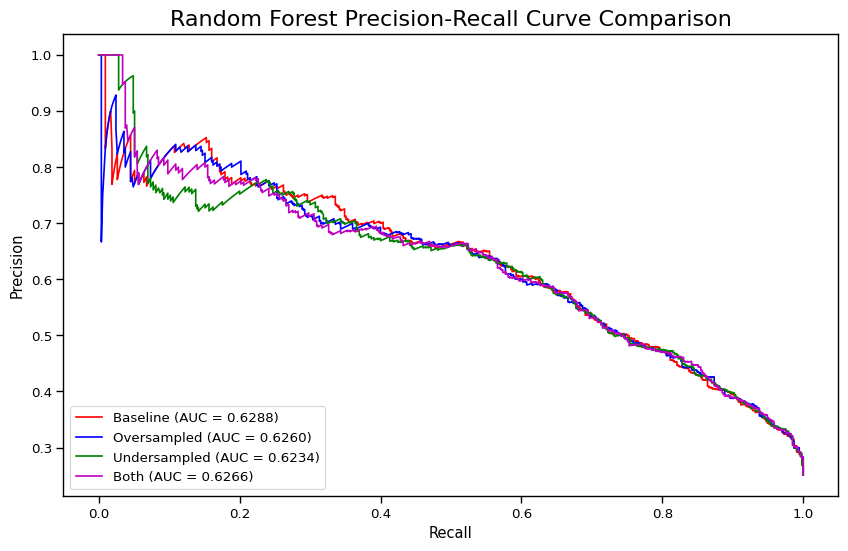

In [88]:
plot_model_comparison(model_rf, model_ros_rf, model_rus_rf, model_rous_rf, X_test, y_test, "Random Forest")

Different with the Logistic Regression Models, it has the same Area as the undersampled one, making it both the lowest value between baseline and Oversampled model.

In [89]:
cf_summary_all = pd.DataFrame([['Recall', recall_lr, recall_ros_lr,recall_rus_lr,recall_rous_lr, recall_rf, recall_ros_rf,recall_rus_rf,recall_rous_rf],
                     ['Precision', precision_lr,precision_ros_lr,precision_rus_lr, precision_rous_lr,precision_rf,precision_ros_rf,precision_rus_rf,precision_rous_rf]],
                    columns=['Score', 'Baseline LR', 'Oversampled LR', 'Undersampled LR','Mixed Sampling LR', 'Baseline RF', 'Oversampled RF', 'Undersampled RF','Mixed Sampling RF'])

cf_summary_all.set_index('Score', inplace=True)

In [90]:
cf_summary_all

,Baseline LR,Oversampled LR,Undersampled LR,Mixed Sampling LR,Baseline RF,Oversampled RF,Undersampled RF,Mixed Sampling RF
Score,,,,,,,,
Recall,0.524528,0.760377,0.767925,0.762264,0.516981,0.747170,0.752830,0.741509
Precision,0.628959,0.477488,0.475467,0.476978,0.658654,0.497487,0.492593,0.476978


### Conclusion ###

After tinkering around with models and its sample dataset, what we will propose to the company is to use the Undersampled Logistic Regression Model, since it is the best model to predict churn.

Data Imbalance proven to be a quite hindrance for classification models and lots of methods could be done to improve its performance. In this article we surmise that the Undersampling the dataset made the models performed much better than the baseline models, albeit slightly better than Oversampling the dataset.

Considering that we don't tweak around hyper-parameters and tinkering with other models in this article, perhaps for further research, weighted Random Forest and Cross Validating Boosting models will yield better recall compared to this article's models.

### References ###



*   [1] https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
*   [2] Davis, J. & Goadrich, M.(2006) - Relationship Between Precision-Recall and ROC Curves
*   [3] Weiss, G.M & Provost, F. (2001) - The Effect of Class Distribution on Classifier Learning: An Emperical Study



